# Итоговый проект. Бриф “Агентство недвижимости”

## Постановка задачи

К вам обратился представитель крупного агентства недвижимости со
следующей проблемой:
«Мои риелторы тратят катастрофически много времени на сортировку
объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да
и, сказать по правде, качество анализа не дотягивают до уровня конкурентов.
Это сказывается на наших финансовых показателях.
- Бизнес задача — разработать модель, которая позволила бы обойти конкурентов по скорости и качеству совершения сделок. 
- Еухническая задача: разработать сервис для предсказания стоимости домов на основе истории предложений.

## Знакомство с данными

### Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from geopy.geocoders import Nominatim
import warnings
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import optuna
import pickle
warnings.simplefilter('ignore')

C:\Users\stroy\AppData\Roaming\Python\Python39\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Зафиксируем random state
RANDOM_SEED = 42

### Добавим функции, которые будем использовать в работе

In [4]:
def mape(y_true, y_pred):
    """Функция для рассчет MAPE"""
    return np.mean(np.abs((y_pred-y_true)/y_true))


def iqr(col):
    """Функция для рассчета межквартильного размаха"""
    return col.quantile(0.75) - col.quantile(0.25)


def get_log_column(col):
    """Функция получения колонки с логарифмированными значениями"""
    return np.log(df[col][df[col] > 0].dropna() +1)


def correlation(dataset, threshold):
    """Функция отсеивания колонок с корреляцией выше заданного порога"""
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


def get_school_lists(schoolFacts):
    """Функцию для получения характеристик из schoolFacts"""
    r_list = str(list((schoolFacts).values())[0])
    dist_list = str(list((schoolFacts).values())[1]['Distance'])
    g_list = str(list((schoolFacts).values())[1]['Grades'])
    return [r_list, dist_list, g_list]


def get_unique_from_lists_df_column(colunm):
    """Функция получения уникальных значений в колонках со списками"""
    res = []
    for i in colunm:
        res.extend(i)
    res = list(set(res))
    return res


def get_schools_stats(row):
    """Функция получения признаков из характеристик школ: количество школ,
    максимальныц рейтинг, средний рейтинг, минимальное расстояние, среднее расстояние"""
    r_list = row.ratings
    nr_list = []
    zero_list = ['', 'NA', 'NR', 'None']
    for r in r_list:
        if '/' in r:
            r = r.split('/')[0]
        if r in zero_list:
            r = '0'
        nr_list.append(int(r))
    
    max_r, mean_r, min_dist, mean_dist = None, None, None, None
    number = len(nr_list)
    if number > 0:
        max_r = max(nr_list)
        mean_r = round(sum(nr_list) / number, 2)

        dist_list = row.distance

        ndist_list = []
        for d in dist_list:
            d = d.replace('mi', '')
            d = d.replace(' ', '')
            try:
                ndist_list.append(float(d))
            except:
                print('distError', i, dist_list)
        try:
            min_dist = min(ndist_list)
            mean_dist = round(sum(ndist_list) / number, 2)
        except:
            print('distError2', i, dist_list)
        

    return number, max_r, mean_r, min_dist, mean_dist


def get_grades_range(grade):
    """Функция получения списка классов обучения в ближайших школах"""
    delim_list = ['–', ' to ', '-', '-', '–']
    g0 = False
    for d in delim_list:
        if d in grade:
            ranges = grade.split(d)
            if len(ranges) == 1:
                g0 = ranges[0]
                g_list = list(grades[g0])
                break
            g0 = ranges[0]
            g1 = ranges[1]
            break
    if not g0:
        print(grade)
        g_list = [grades[grade]]
        return g_list
    try:
        g0 = grades[g0]
    except:
        print(i, grade)
        return []
    try:
        g1 = grades[g1]
    except:
        print(i, grade)
        return list(grades[g0])

    g_list = list(range(g0, g1 + 1))
    return g_list


def get_grades_list(grades_list):
    """Функция получения признаков: список классов и количество классов в ближайших школах"""
    new_grades_list = []
    zero_list = ['NA', 'N/A', None]
    
    for g in grades_list:
        if g in zero_list:
            continue
        g = g.lower()
        g2 = False
        if ', ' in g:
            g2 = []
            g2_list = g.split(', ')
            for g2i in g2_list[1: ]:
                g2.extend(get_grades_range(g2i))
                g = g.replace(g2i, '')
            g = g.replace(', ', '')

            
        g_list = get_grades_range(g)
        if g2:
            g_list.extend(g2)
        new_grades_list.extend(g_list)
    new_grades_list = list(set(new_grades_list))
    return new_grades_list, len(new_grades_list)


def fillna_beds(sqft_replaced):
    """Функция заполнения пропусков в beds с помощью sqft"""
    beds = round(sqft_replaced / beds_num)
    if beds == 0:
        beds = 1
    if beds > 29:
        beds = 29
    return beds


def fillna_bath(sqft_replaced):
    """Функция заполнения bath с помощью sqft"""
    bath = round((sqft_replaced / bath_num) * 2) / 2
    if bath == 0: 
        bath = 1
    if bath == 0.5:
        bath = 1
    if bath > 30:
        bath = 30
    return bath

In [5]:
df = pd.read_csv('data.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [9]:
df

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,"$1,249,000"
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,"$674,999"
377182,for sale,NaN,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,NaN,NaN,NaN,"$528,000"
377183,NaN,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,NaN,NaN,"$34,500"


In [10]:
df.apply(lambda x: x.nunique())

status             159
private pool         1
propertyType      1280
street          337076
baths              229
homeFacts       321009
fireplace         1653
city              2026
schools         297365
sqft             25405
zipcode           4549
beds              1184
state               39
stories            348
mls-id           24907
PrivatePool          2
MlsId           232944
target           43939
dtype: int64

In [11]:
df.isna().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

Данные очень грязные, с большим количеством пропусков. Многие категориальные данные с очень большим количеством уникальных значений.

### Отсеим мусорные данные

In [7]:
df.status = df.status.str.lower()
df.propertyType = df.propertyType.str.lower()

df = df[~df.target.isna()] # удалим данные с пропусками в таргете
df = df[~(df.propertyType == 'lot/land')] # удалим участки
df = df[~((df.propertyType == 'land') & (df.sqft == '0'))]

df.drop(['mls-id', 'MlsId'], axis=1, inplace=True) # эти колонки сами по себе нам не дают ни какой информации, только если
# пробовать парсить по ним дополнительные данные, но на это нет времени, удалим их

### Вытащим информацию из homeFacts

In [13]:
df['atAGlanceFacts'] = df.homeFacts.apply(lambda x: eval(x)['atAGlanceFacts'])

df['atAGlanceFactsLen'] = df['atAGlanceFacts'].apply(lambda x: len(x))

new_cols = list(df.from_dict(eval(df.homeFacts[0])['atAGlanceFacts'])['factLabel'])

In [17]:
new_cols

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [18]:
eval(df.homeFacts[0])

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': None, 'factLabel': 'lotsize'},
  {'factValue': '$144', 'factLabel': 'Price/sqft'}]}

In [19]:
df[new_cols] = None
df[new_cols] = df.atAGlanceFacts.apply(lambda x: pd.DataFrame(x)['factValue'])

In [20]:
df.drop(['homeFacts', 'atAGlanceFacts'], axis=1, inplace=True)

### Удалим так же данные с арендой

In [21]:
df.status.fillna('unknown', inplace=True)

In [22]:
df[df.status.str.contains('rent')].target

547        $5,500/mo
609       $10,500/mo
2075       $6,390/mo
3025       $1,200/mo
3645       $3,600/mo
             ...    
371791       $890/mo
372459     $2,500/mo
374288     $2,000/mo
375550     $1,500/mo
376976     $1,900/mo
Name: target, Length: 412, dtype: object

In [23]:
df = df[~df.status.str.contains('rent')]

### Обработаем колонки с информацией о бассейнах

In [24]:
# Объедимим две колонки в одну и сделаем бинарным
df['private_pool'] = df['PrivatePool']
df['private_pool'] = np.where(df['private_pool'].isna(), df['private pool'], df['private_pool'])
df.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)
df['private_pool'] = df['private_pool'].str.lower()
df['private_pool'] = df['private_pool'].str.replace('yes', '1')
df['private_pool'] = df['private_pool'].fillna(0)

### Обработаем target

In [25]:
df['target'] = df['target'].str.replace(r'[^0-9]', '', regex=True)

df.target = df.target.astype('float')

<AxesSubplot: ylabel='Frequency'>

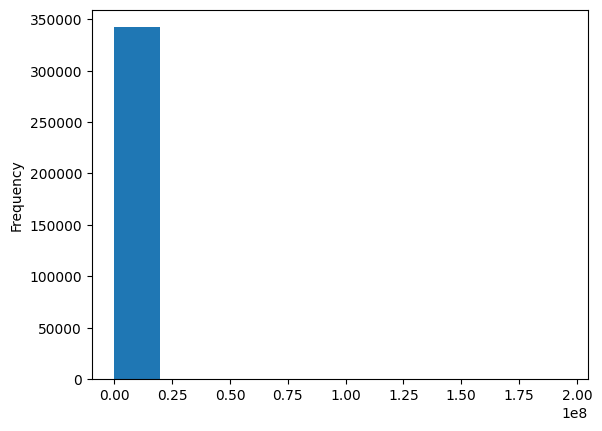

In [28]:
df.target.plot(kind='hist')

Большая часть значений до 250000. Для начала удалим все что ниже и выше 1 и 99 квантиля

In [29]:
res = df.target.quantile([0.01, 0.99])

In [30]:
res

0.01      17900.0
0.99    6250000.0
Name: target, dtype: float64

<AxesSubplot: ylabel='Frequency'>

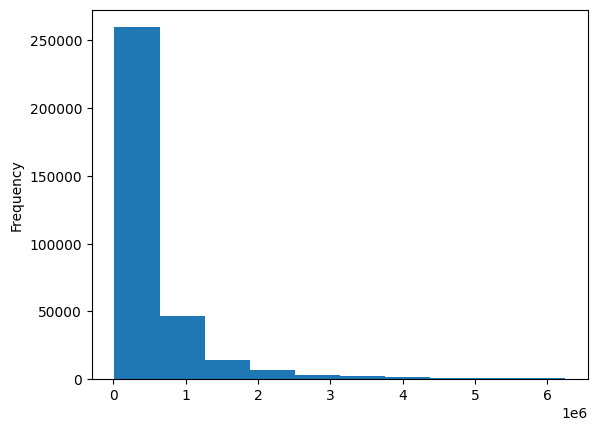

In [31]:
df.loc[(df.target > res[0.01]) & (df.target < res[0.99])].target.plot(kind='hist')

In [32]:
df = df.loc[(df.target > res[0.01]) & (df.target < res[0.99])]

### Заполним пропуски в sqft

In [33]:
df[df.sqft.isna()]

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,beds,...,stories,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,private_pool
7,active,NaN,6094 Mingle Dr,NaN,NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,...,NaN,68000.0,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,0
15,new,2 story,930 52nd St,NaN,NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,...,NaN,1650000.0,1905,1905,,Steam Heating,,"2,003 Sq. Ft.",None,0
26,active,NaN,5755 SW 123 Ave,"1,000",NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,...,NaN,799000.0,,,,,,—,None,0
40,active,NaN,1104 Rotonda Cir,NaN,NaN,ROTONDA WEST,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,...,NaN,54000.0,,,,,,—,None,0
42,active,NaN,MLS #: STRI1057289,NaN,NaN,New York,"[{'rating': ['NR', 'NR', '9', '8', '8', '2', '...",NaN,10006,NaN,...,NaN,850000.0,,2003,,,,—,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377118,price change,colonial,1231 78 St,NaN,NaN,Brooklyn,"[{'rating': ['8', '10', '4'], 'data': {'Distan...",NaN,11228,NaN,...,NaN,1150000.0,1920,1920,,Steam Heating,,"1,950 Sq. Ft.",None,0
377141,active,NaN,Mantova Ct,NaN,NaN,ORLANDO,"[{'rating': ['7', '6', 'NR', 'NR', '7'], 'data...",NaN,32836,NaN,...,NaN,400000.0,,,,,,—,None,0
377146,for sale,single-family home,206/208 N Randolph St,NaN,NaN,Indianapolis,"[{'rating': ['1/10'], 'data': {'Distance': ['0...",NaN,46201,NaN,...,NaN,50000.0,1910,,,,,5488 sqft,None,0
377154,active,NaN,2104 Russell Ave,NaN,NaN,Charlotte,"[{'rating': ['2', '3', '3'], 'data': {'Distanc...",NaN,28216,NaN,...,NaN,99990.0,,,,,,"6,970 Sq. Ft.",None,0


Используем для этого цену за квадратный фут

In [34]:
df['Price/sqft'].value_counts()

               4514
No Data        1017
No Info         927
$125/sqft       789
$132/sqft       764
               ... 
$2,012            1
$2,556/sqft       1
$2,040/sqft       1
$2,609/sqft       1
$1,641/sqft       1
Name: Price/sqft, Length: 5324, dtype: int64

In [35]:
df['Price/sqft'] = df['Price/sqft'].str.replace(r'[^0-9]', '', regex=True)
df['Price/sqft'][df['Price/sqft'] == ''] = np.NaN
df['Price/sqft'] = df['Price/sqft'].astype('float')

In [38]:
df['Price/sqft'].value_counts()

125.0     1713
128.0     1702
121.0     1701
123.0     1699
127.0     1693
          ... 
2179.0       1
3200.0       1
2478.0       1
1796.0       1
1641.0       1
Name: Price/sqft, Length: 2340, dtype: int64

In [39]:
df['Price/sqft'][df['Price/sqft'] == 0] = np.NaN

In [40]:
df['Price/sqft'].describe()

count    3.024590e+05
mean     4.054445e+02
std      1.924138e+04
min      1.000000e+00
25%      1.230000e+02
50%      1.770000e+02
75%      2.960000e+02
max      5.000000e+06
Name: Price/sqft, dtype: float64

<AxesSubplot: ylabel='Frequency'>

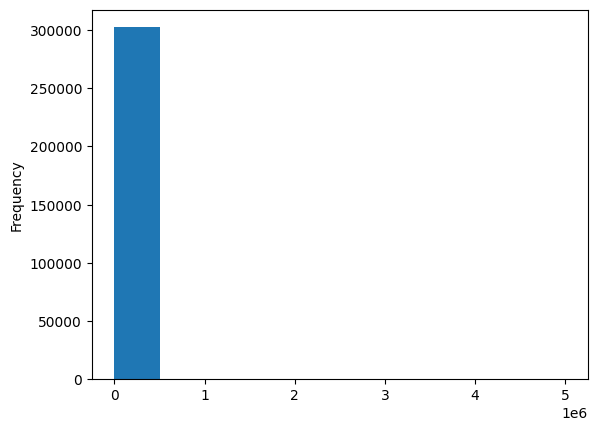

In [41]:
df['Price/sqft'].plot(kind='hist')

убрать верхние и нижние квантили, где цена слишком мала или высока

<AxesSubplot: ylabel='Frequency'>

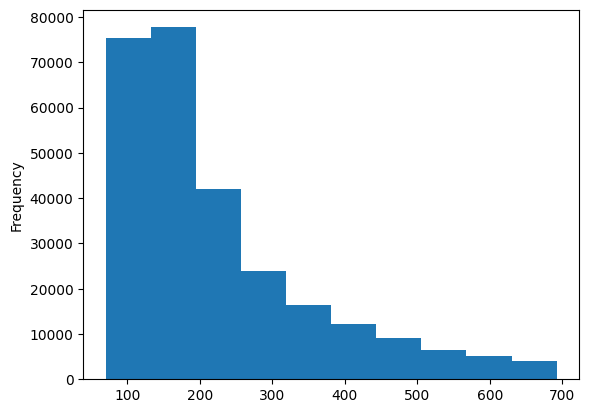

In [42]:
res = df['Price/sqft'].quantile([0.05, 0.95])
df.loc[(df['Price/sqft'] > res[0.05]) & (df['Price/sqft'] < res[0.95])]['Price/sqft'].plot(kind='hist')

In [43]:
df.loc[(df['Price/sqft'] < res[0.05]) | (df['Price/sqft'] > res[0.95]), 'Price/sqft'] = np.NaN
df['sqft_recovered'] = df.target / df['Price/sqft']
df['sqft_recovered'] = df['sqft_recovered'].round()
df['sqft'] = df['sqft'].str.replace(r'[^0-9]', '', regex=True)
df['sqft'][df['sqft'] == ''] = np.NaN
df['sqft'] = df['sqft'].astype('float')
df['sqft'][df['sqft'] == 0] = np.NaN

Посмотрим на сколько отличаются полученные значения sqft с помощью Price/sqft от реальных

In [50]:
df_sqtf = df[['sqft', 'sqft_recovered']]

df_sqtf.dropna(inplace=True)

<AxesSubplot: >

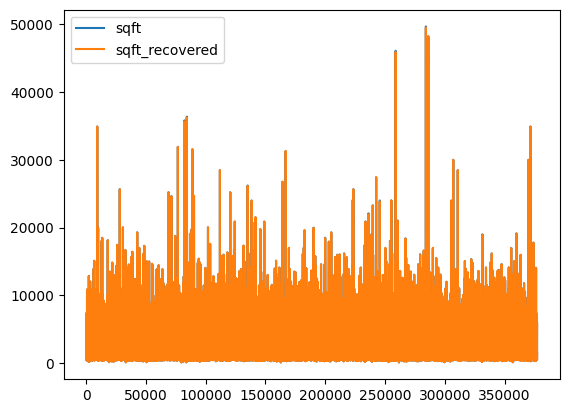

In [52]:
df_sqtf.plot()

In [53]:
df_sqtf['delta'] = df.sqft - df.sqft_recovered

<AxesSubplot: >

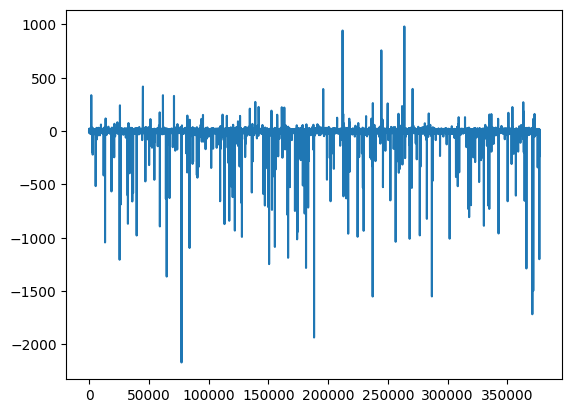

In [54]:
df_sqtf.delta.plot()

In [55]:
df_sqtf.delta.mean()

-0.3143306228673025

In [56]:
df_sqtf.describe()

,sqft,sqft_recovered,delta
count,271663.000000,271663.000000,271663.000000
mean,2179.012633,2179.326964,-0.314331
std,1341.434332,1341.448262,17.821400
min,100.000000,100.000000,-2169.000000
25%,1335.500000,1336.000000,-2.000000
50%,1876.000000,1876.000000,0.000000
75%,2632.000000,2632.000000,2.000000
max,49670.000000,49505.000000,980.000000


Расхожения не велики, заменим недостающие значения в sqft

In [58]:
df['sqft_replaced'] = np.where(df.sqft.isna(), df.sqft_recovered, df.sqft)

In [59]:
df.sqft.isna().sum()

22934

In [60]:
df['sqft_replaced'].isna().sum()

22075

In [61]:
df.drop(['sqft', 'Price/sqft', 'sqft_recovered'], axis=1, inplace=True)

### Уберем объявления где нет информации о спальнях, ванных и площади, в таком случае ничего почти не известно об этих объявлениях

In [62]:
df = df[~(df.baths.isna() & df.beds.isna() & df.sqft_replaced.isna())]
df.reset_index(drop=True, inplace=True)

In [64]:
df.isna().sum()

status                 0
propertyType       21457
street                 0
baths              61850
fireplace         223685
city                   9
schools                0
zipcode                0
beds               46823
state                  0
stories           104058
target                 0
Year built          3336
Remodeled year     25643
Heating             3336
Cooling             3336
Parking             3336
lotsize            27461
private_pool           0
sqft_replaced       9319
dtype: int64

### Обработка Propertype

In [65]:
df.propertyType.nunique() # слишком много уникальных значений

1234

In [66]:
df.propertyType = df.propertyType.astype("string")
df.propertyType = df.propertyType.str.replace("-", " ")
df.propertyType = df.propertyType.str.replace("/", " ")
df.propertyType.nunique()

1225

На сайте https://www.bankrate.com/real-estate/types-of-houses/ нашел основные типы и стили домов в США, попорбую вытащить их из propertyType

In [67]:
df['type'] = np.NaN

sf = ['single family', 'singlefamilyresidence', 'single detached', 'detached']
for i in sf:
    df['type'][df.propertyType.str.contains(i)] = 'single family'

cond = ['co op', 'condo', 'penthouse', 'condominium', 'coop', 'apartment', 'high rise', 'mid rise']
for i in cond:
    df['type'][df.propertyType.str.contains(i)] = 'condo'

df['type'][df.propertyType.str.contains('townhouse')] = 'townhouse'

multi = ['multi family', 'cluster home', 'duplex', 'fourplex', 'attached', 'multiple occupancy']
for i in multi:
    df['type'][df.propertyType.str.contains(i)] = 'multi family'

mod = ['modular home', 'manufactured', 'mobile']
for i in mod:
    df['type'][df.propertyType.str.contains(i)] = 'modular'

df['type'].value_counts()

single family    187387
condo             56540
townhouse         18244
multi family      12218
modular            3417
Name: type, dtype: int64

Попробуем вытащить из этого признака стиль здания

In [68]:
df['style'] = np.NaN

bung = ['bungalow', 'craftsman', 'queen', 'cape cod']
for i in bung:
    df['style'][df.propertyType.str.contains(i)] = 'bungalow'

ranch = ['ranch', 'farmhouse']
for i in ranch:
    df['style'][df.propertyType.str.contains(i)] = 'ranch'

df['style'][df.propertyType.str.contains('colonial')] = 'colonial'

df['style'][df.propertyType.str.contains('contemporary')] = 'contemporary'

med = ['mediterranean', 'spanish', 'florida', 'garden home']
for i in med:
    df['style'][df.propertyType.str.contains(i)] = 'mediterranean'

trad = ['traditional', 'victorian', 'tudor', 'english', 'european', 'french']
for i in trad:
    df['style'][df.propertyType.str.contains(i)] = 'traditional'

df['style'].value_counts()

traditional      10075
contemporary      3866
ranch             2742
mediterranean     1891
bungalow          1209
colonial          1128
Name: style, dtype: int64

Стилей получилось не много, так как это маловероятно, что квартиры, сделаю из них отдельную категорию type

In [69]:
df['type'] = np.where((df['type'].isna() & df['style'].notna()), 'unknown house', df['type'])

df['type'].value_counts()

single family    187387
condo             56540
townhouse         18244
unknown house     17442
multi family      12218
modular            3417
Name: type, dtype: int64

In [70]:
df['type'].isna().sum()

27962

In [71]:
df['type'][df['type'].isna()] = 'another'

In [72]:
df['type'].value_counts()

single family    187387
condo             56540
another           27962
townhouse         18244
unknown house     17442
multi family      12218
modular            3417
Name: type, dtype: int64

Удалим недвижимосить, где тип указан land и нет площади помещения, с большой долей вероятности это не ошибка типа, а продажа земли.

In [73]:
df = df[~((df.propertyType == 'land') & (df.sqft_replaced.isna()))]

В propertyType так же встречаются указания на этажность, попробуем сохранить эту информацию для заполнения пропусков в соответствующей колонке

In [74]:
df['recovered_stories'] = None
df['recovered_stories'][df.propertyType.str.contains('stor')] = df.propertyType[df.propertyType.str.contains('stor')]
df.drop('propertyType', axis=1, inplace=True)

### Обработаем status

In [78]:
df.status.value_counts()

for sale                   175928
active                      79195
unknown                     35848
new construction             5407
foreclosure                  4864
                            ...  
coming soon: dec 25.            1
pending w/backup wanted         1
pending backups wanted          1
contingent   no show            1
coming soon: dec 23.            1
Name: status, Length: 144, dtype: int64

Слишком много уникальных значений, преобразуем все в продающиеся и все остальные

In [79]:
fs = ['for sale', 'active']

df['new_status'] = np.NaN
for i in fs:
    df['new_status'][df.status.str.contains(i)] = 'for sale'

df['new_status'][df['new_status'].isna()] = 'another'

In [80]:
df.new_status.value_counts()

for sale    256381
another      62374
Name: new_status, dtype: int64

In [81]:
df.drop('status', axis=1, inplace=True)

### обработка street не дала каких то результатов, слишком много значений

In [408]:
# df.street = df.street.str.lower()
# df['house_number'] = df.street.str.split(' ')
# df['house_number'] = df['house_number'].apply(lambda x: x[0])
# df['new_street'] = df.street.str.split(' ')
# df.street[df.street.str.contains('disclosed')] = 'undisclosed'
# df.street[df.street.str.contains('buildable')] = df.street[df.street.str.contains('buildable')].str.replace('buildable plan: ', '')
# df.street[df.street.str.contains('address not available')] = 'undisclosed'

# df.house_number[df.street == 'undisclosed'] = ''

# df.house_number[df.house_number == 'buildable'] = ''

# df.reset_index(drop=True, inplace=True)

# %%time
# for i, row in df.iterrows():
#     df.loc[i, 'street'] = row.street.replace(row.house_number, '')

# df.street[df.street.str.contains('address')] = 'undisclosed'

# df.street = df.street.str.removeprefix(' ')

# df.street = df.street.str.removeprefix(' ')

# df.street.value_counts()

Все равно слишком много значений

In [82]:
df.drop(['street'], axis=1, inplace=True)

### Заполним пропуски в city с помощью геокодинга

In [83]:
df.city = df.city.str.lower()

In [84]:
df[df.city.isna()]

,baths,fireplace,city,schools,zipcode,beds,state,stories,target,Year built,...,Heating,Cooling,Parking,lotsize,private_pool,sqft_replaced,type,style,recovered_stories,new_status
6713,2,NaN,NaN,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",32686,1,FL,2,1495000.0,2000,...,Central Heat,"Ceiling Fans, Central Cooling",Covered Parking,None,0,1016.0,single family,NaN,None,for sale
111921,Bathrooms: 6,NaN,NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...",20003,5 bd,MA,NaN,1650000.0,2000,...,Electric,,"Carport, Attached Garage",-- sqft lot,1,5905.0,single family,NaN,None,for sale
145948,7.5,NaN,NaN,"[{'rating': ['2', '4', '6', '4', '3', '10', 'N...",34741,7,FL,2,675000.0,2015,...,"Central Heat, Electric Heat","Central Cooling, Electric Cooling","Circular Drive, Covered Parking",None,0,NaN,single family,NaN,None,for sale
238804,5.5,NaN,NaN,"[{'rating': ['4', '9', '6', '5', '3', 'NR', 'N...",34747,9,FL,2,595000.0,2016,...,"Central Heat, Gas Heat","Central Cooling, Gas Cooling","Covered Parking, Pavers",None,0,NaN,single family,NaN,None,for sale
241774,9,NaN,NaN,"[{'rating': ['4', '3', '6', '5', '9', 'NR', 'N...",34747,10,FL,2,890000.0,2018,...,"Central Heat, Electric Heat","Central Cooling, Electric Cooling",Driveway,None,0,5141.0,single family,NaN,None,for sale
264999,2,NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",34747,2,FL,Condo 5+ Stories,343300.0,2019,...,Electric Heat,Central Cooling,2 Or More Spaces,None,0,NaN,condo,NaN,None,for sale
296686,Bathrooms: 4,NaN,NaN,"[{'rating': ['10/10', '3/10'], 'data': {'Dista...",33126,6 bd,FL,NaN,340000.0,1991,...,,Other,,-- sqft lot,0,NaN,single family,NaN,None,for sale
307582,7,NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",34747,7,FL,NaN,1012600.0,2019,...,Electric Heat,Central Cooling,"Driveway, Other Parking",None,0,NaN,single family,NaN,None,for sale
317102,0,NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",77032,10.0,TX,NaN,2700000.0,1982,...,,Other Cooling,,192535,0,30000.0,unknown house,ranch,None,for sale


In [85]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('34741')
print(location)

Kissimmee, Osceola County, Florida, 34741, United States


In [86]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('77032')
print(location)

Houston, Harris County, Texas, 77032, United States


In [87]:
df.loc[6621, 'city'] = 'kissimmee'
df.loc[312721, 'city'] = 'houston'

In [359]:
df[df.city == ' ']

,baths,city,zipcode,beds,state,target,year_built,remodeled_year,heating,cooling,...,private_pool,sqft,type,status,fireplace,number_of_school,max_school_rating,mean_school_rating,min_school_dist,num_of_classes
52319,2,,11207,1,ny,1200000.0,1905,1905,0,0,...,0,2900.0,another,1,0,8,5,3.00,0.1,10
64068,2,,34746,1,fl,149900.0,1990,1990,0,0,...,0,1296.0,another,1,0,5,10,5.60,4.5,14
139408,6,,33179,3,ba,225000.0,1900,1900,0,0,...,0,7728.0,another,1,0,0,0,0.00,100.0,0
216122,2,,28677,1,nc,96500.0,1966,1966,0,1,...,0,960.0,unknown house,1,0,0,0,0.00,100.0,0
222705,2,,32822,1,fl,110000.0,1990,1990,0,0,...,0,934.0,another,1,0,5,7,4.60,0.7,13
264052,2,,28677,1,nc,123400.0,1966,1966,0,1,...,0,1476.0,another,1,0,0,0,0.00,100.0,0
272623,2,,11236,1,ny,820000.0,1960,1960,0,0,...,0,1561.0,another,1,0,4,5,2.25,0.2,10


In [360]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('11207, United States')
print(location)

Kings County, City of New York, New York, 11207, United States


In [361]:
df.loc[52319, 'city'] = 'new york'

In [362]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('34746, United States')
print(location)

Osceola County, Florida, 34746, United States


In [363]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('33179, United States')
print(location)

Miami-Dade County, Florida, 33179, United States


In [364]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('28677, United States')
print(location)

Iredell County, North Carolina, 28677, United States


In [365]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('32822, United States')
print(location)

Orange County, Florida, 32822, United States


In [366]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('28677, United States')
print(location)

Iredell County, North Carolina, 28677, United States


In [367]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('11236, United States')
print(location)

Kings County, City of New York, New York, 11236, United States


In [368]:
df.loc[272623, 'city'] = 'new york'

In [370]:
df.city[df.city == ' '] = np.NaN

In [371]:
df[df.city == '--']

,baths,city,zipcode,beds,state,target,year_built,remodeled_year,heating,cooling,...,private_pool,sqft,type,status,fireplace,number_of_school,max_school_rating,mean_school_rating,min_school_dist,num_of_classes
12363,6,--,32821,3,fl,155900.0,2007,2007,1,1,...,1,1450.0,condo,0,0,3,6,4.67,4.0,14
263848,6,--,78501,3,fl,229000.0,2018,2018,1,1,...,0,1595.0,townhouse,0,0,3,7,3.67,0.4,14


In [373]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('32821, United States')
print(location)

Orange County, Florida, 32821, United States


In [374]:
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode('78501, United States')
print(location)

McAllen, Hidalgo County, 78501, United States


In [375]:
df.city[df.city == '--'] = np.NaN

In [380]:
df.dropna(subset='city', inplace = True)

### Обработаем bath

In [90]:
df['baths'] = df['baths'].str.replace(r'[^0-9.]', '', regex=True)

df.baths.value_counts()

2            83656
3            53665
4            21055
2.0          16315
2.5          12770
             ...  
22.0             1
18.0             1
116116116        1
14.0             1
23.0             1
Name: baths, Length: 112, dtype: int64

In [91]:
df.baths[df.baths == ''] = np.NaN
df.baths[df.baths == '..'] = np.NaN
df.baths = df.baths.astype('float')
df.baths.value_counts()

2.0            99971
3.0            64443
4.0            25550
1.0            16014
2.5            12770
               ...  
1111.0             1
5.2                1
116116116.0        1
10101.0            1
28.0               1
Name: baths, Length: 85, dtype: int64

Встречаются очень большие значения baths, заполним пока пропусками значения более 30

In [92]:
df.baths[df.baths > 30] = np.NaN

df.baths.value_counts()

2.00     99971
3.00     64443
4.00     25550
1.00     16014
2.50     12770
         ...  
5.20         1
5.25         1
4.75         1
25.00        1
28.00        1
Name: baths, Length: 61, dtype: int64

In [95]:
df.isna().sum()

baths                 73358
fireplace            219242
city                      0
schools                   0
zipcode                   0
beds                  46782
state                     0
stories               99611
target                    0
Year built              542
Remodeled year        22849
Heating                 542
Cooling                 542
Parking                 542
lotsize               24667
private_pool              0
sqft_replaced          4864
type                      0
style                297844
recovered_stories    311412
new_status                0
dtype: int64

### Обработаем fireplace

Преобразуем признак в бинарный, есть камин или нет.

In [96]:
df.fireplace = df.fireplace.str.lower()
df.fireplace[df.fireplace.isna()] = '0'

df['fire_num'] = df.fireplace.str.replace(r'[^0-9]', '', regex=True)
df.fire_num[df.fire_num == ''] = np.NaN
df.fire_num[df.fire_num.astype('float') > 9] = np.NaN
df.fire_num[df.fire_num.astype('float') == 0] = np.NaN

df['new_fireplace'] = np.NaN

df.new_fireplace[df.fire_num.notna()] = 1
df.new_fireplace[df.fireplace.isna()] = 0

nofp = ['not applicable', '0', 'no', 'decorative', 'electric', 'fireplace yn']
for i in nofp:
    df.new_fireplace[(df.new_fireplace.isna()) & (df.fireplace == i)] = 0

In [101]:
df.new_fireplace.value_counts()

0.0    222187
1.0     18469
Name: new_fireplace, dtype: int64

In [102]:
df.new_fireplace[df.fireplace == 'yes'] = 1

yfp = ['fireplace', 'gas', 'room', 'wood', 'familyrm']
for i in yfp:
    df.new_fireplace[(df.new_fireplace.isna()) & (df.fireplace.str.contains(i))] = 1

df.new_fireplace.value_counts()

0.0    222187
1.0     93906
Name: new_fireplace, dtype: int64

In [103]:
df.new_fireplace.fillna(0, inplace=True)

df.drop('fireplace', axis=1, inplace=True)

### Обработаем schools

Информацию по школам брал отсюда https://en.wikipedia.org/wiki/Education_in_the_United_States#:~:text=Generally%2C%20there%20are%20three%20stages,9%2F10%E2%80%9312).

In [108]:
# Вытащим признаки из schoolFacts
df['schoolFacts'] = df.schools.apply(lambda x: eval(x)[0])
df.reset_index(drop=True, inplace=True)

In [109]:
df.schoolFacts[0].keys()

dict_keys(['rating', 'data', 'name'])

Сделаем признаки из рейтингов школ, дистанции и количества классов, в которых можно обучаться в этих школах

In [115]:
%%time
new_cols = ['ratings', 'distance', 'grades']

for i in range(len(df)):
    df.loc[i, new_cols] = get_school_lists(df.schoolFacts[i])

CPU times: total: 5min 22s
Wall time: 5min 24s


In [116]:
%%time
df.ratings = df.ratings.apply(lambda x: eval(x))
df.distance = df.distance.apply(lambda x: eval(x))
df.grades = df.grades.apply(lambda x: eval(x))

CPU times: total: 17.9 s
Wall time: 17.9 s


In [2]:
# %%time
# ratings = []
# for i in df.ratings:
#     ratings.extend(i)
# ratings = list(set(ratings))

# distance = get_unique_from_lists_df_column(df.distance)

# grades = get_unique_from_lists_df_column(df.grades)

In [125]:
%%time
new_cols = 'number_of_school', 'max_school_rating', 'mean_school_rating', 'min_school_dist', 'mean_school_dist'

for i, row in df.iterrows():
    df.loc[i, new_cols] = get_schools_stats(row)

distError2 3269 []
distError2 5368 []
distError2 11512 []
distError2 16853 []
distError2 19764 []
distError2 21370 []
distError2 36768 []
distError2 41039 []
distError2 45386 []
distError2 45938 []
distError2 52382 []
distError2 53636 []
distError2 54190 []
distError2 55972 []
distError2 58761 []
distError2 60045 []
distError2 62936 []
distError2 64109 []
distError2 65266 []
distError2 70478 []
distError2 73455 []
distError2 76944 []
distError2 79481 []
distError2 85420 []
distError2 89768 []
distError2 94614 []
distError2 95826 []
distError2 97794 []
distError2 106648 []
distError2 110607 []
distError2 111744 []
distError2 117821 []
distError2 123584 []
distError2 125575 []
distError2 127459 []
distError2 130295 []
distError2 131788 []
distError2 134306 []
distError2 139691 []
distError2 149561 []
distError2 151329 []
distError2 152137 []
distError2 157731 []
distError2 177277 []
distError2 183031 []
distError2 190095 []
distError2 195892 []
distError2 199768 []
distError2 222286 []
d

In [126]:
grades = {'preschool': 3, 'pk': 3, 'k': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, 
          '7': 11, '8': 12, '9': 13, '10': 14, '11': 15, '12': 16} # заменим класс на возраст школьников

In [129]:
%%time
df['new_grades_list'] = None
df['num_of_classes'] = None
for i, row in df.iterrows():
    df.loc[i, ['new_grades_list', 'num_of_classes']] = get_grades_list(row.grades)

9
pk
pk
pk
9
pk
pk
pk
8
9
k
6
9
6
8
6
9
12
9
6
pk
6
6
pk
9
pk
9
5
9
6
9
9
pk
8
6
7
6
9
9
9
pk
6
8
6
9
8
9
pk
pk
pk
pk
8
9
9
pk
9
8
9
6
9
6
pk
pk
9
9
pk
6
9
6
9
k
8
6
6
9
9
12
6
8
6
9
9
12
6
9
6
6
8
6
pk
6
10
6
9
pk
9
6
6
6
6
5
6
12
8
8
9
9
8
8
9
6
8
pk
pk
6
6
6
9
9
9
9
pk
pk
8
12
9
8
8
9
12
6
6
k
9
6
6
9
pk
9
9
pk
9
6
9
8
6
6
6
6
9
6
8
pk
6
9
pk
9
12
pk
6
6
9
k
6
12
6
9
8
9
8
8
9
9
9
6
9
6
6
pk
6
9
8
10
9
k
6
8
6
6
9
9
12
12
8
9
8
6
pk
pk
9
6
6
8
pk
9
6
6
8
pk
k
6
k
pk
6
10
9
5
12
pk
6
9
5
6
12
6
12
12
9
8
12
6
6
9
12
6
6
pk
8
8
8
8
6
9
9
9
9
6
9
6
pk
8
pk
pk
8
9
3
6
6
9
9
k
9
pk
pk
9
k
9
6
8
6
9
9
pk
9
6
6
pk
pk
9
8
6
9
9
12
9
9
9
8
5
6
8
9
6
6
9
6
6
pk
8
9
6
5
6
pk
9
pk
9
8
pk
6
6
5
6
6
8
9
9
8
9
k
6
12
6
8
7
8
6
9
8
pk
pk
8
8
6
6
8
6
6
9
9
6
pk
9
9
12
5
6
8
8
6
9
9
6
9
9
k
9
9
9
8
9
6
8
9
9
9
6
9
12
pk
6
5
9
pk
pk
pk
12
pk
9
6
9
9
9
5
6
6
6
6
6
9
9
8
12
9
6
9
12
5
6
9
6
12
k
pk
6
pk
6
8
6
pk
pk
9
9
pk
7
pk
6
6
6
6
k
9
12
6
12
pk
pk
1
5
pk
6
8
12
8
9
6
9
9
6
pk
6
6
6
6
6
6
6
9
12
6
9

9
pk
pk
9
9
9
9
8
6
9
9
12
8
pk
6
9
8
pk
9
6
6
9
5
9
6
9
9
6
6
pk
pk
9
9
pk
6
8
pk
6
6
6
6
9
6
9
6
pk
pk
9
6
8
12
pk
9
8
9
9
6
pk
9
9
8
8
6
6
9
9
6
9
10
9
8
6
8
pk
6
10
9
8
6
9
k
pk
6
9
6
9
8
9
9
6
6
6
12
6
9
9
9
pk
6
9
9
pk
pk
6
9
k
pk
9
6
k
pk
pk
6
8
8
9
9
9
6
8
pk
6
9
6
12
9
8
9
9
9
6
5
6
6
8
9
6
9
6
12
6
pk
6
k
6
9
pk
5
6
6
pk
pk
k
pk
6
8
9
9
5
pk
pk
8
12
9
pk
9
6
9
pk
6
5
6
9
9
6
8
10
6
6
pk
pk
9
9
6
9
9
6
6
8
9
9
8
9
6
7
6
12
9
6
6
6
5
6
9
6
9
6
6
6
6
5
6
6
9
k
8
6
9
9
pk
9
pk
9
8
10
6
8
6
pk
8
6
6
6
8
6
6
6
6
8
12
9
pk
8
8
9
pk
pk
8
6
9
9
6
8
12
9
k
9
6
6
pk
pk
6
6
9
8
pk
6
9
9
9
8
9
9
8
6
9
8
8
pk
6
9
8
9
pk
6
6
6
9
6
9
6
10
9
6
6
6
pk
12
9
8
6
8
6
6
6
9
8
9
9
5
6
9
6
6
9
pk
6
6
6
8
6
pk
pk
9
6
6
pk
6
6
8
8
6
6
pk
pk
10
9
8
pk
6
pk
pk
6
9
9
9
6
9
9
6
6
8
6
9
9
9
6
9
6
9
pk
10
6
9
8
9
9
pk
9
12
6
9
1
5
pk
k
6
6
9
pk
pk
6
6
pk
8
9
6
pk
6
6
6
9
6
6
9
10
9
6
9
6
8
9
6
5
pk
12
6
8
6
pk
12
6
9
6
9
9
pk
9
9
8
8
9
6
pk
9
12
pk
10
12
6
pk
5
6
6
6
12
6
12
6
9
6
6
9
pk
pk
5
pk
9
6
9
6
6
6

In [131]:
df.drop(['schools', 'ratings', 'distance', 'grades'], axis=1, inplace=True)
df.drop(['fire_num', 'schoolFacts', 'new_grades_list'], axis=1, inplace=True)
df.drop(['style'], axis=1, inplace=True)

### Обработаем beds

In [134]:
df.beds

0              4
1         3 Beds
2         3 Beds
3         5 Beds
4         2 Beds
           ...  
318750         2
318751         5
318752    3 Beds
318753    3 Beds
318754         3
Name: beds, Length: 318755, dtype: object

In [135]:
df['beds'].str.replace(r'[0-9]', '', regex=True).value_counts()

 Beds                                                                                                                 127093
                                                                                                                       81057
 bd                                                                                                                    30467
.                                                                                                                      17992
Baths                                                                                                                  13845
-- bd                                                                                                                    822
Bath                                                                                                                     381
                                                                                                                         283


In [3]:
nan_list = ['bath', 'sqft', 'acres'] # тут явная ошибка, удалим такие значения

In [137]:
df['beds'].str.contains('acres')

0         False
1         False
2         False
3         False
4         False
          ...  
318750    False
318751    False
318752    False
318753    False
318754    False
Name: beds, Length: 318755, dtype: object

In [138]:
df['beds'] = df['beds'].fillna('unknown')

In [139]:
%%time
df.beds = df.beds.str.lower()
for i in nan_list:
    df['beds'][df['beds'].str.contains(i)] = 'unknown'

CPU times: total: 516 ms
Wall time: 520 ms


In [140]:
df['beds'].str.replace(r'[0-9]', '', regex=True).value_counts()

 beds                                                                                                                 127093
                                                                                                                       81057
unknown                                                                                                                61036
 bd                                                                                                                    30467
.                                                                                                                      17992
-- bd                                                                                                                    822
                                                                                                                         283
based on redfin's st johns data, we estimate the home's value is $,, which is .% less than its current list price.         1


In [141]:
df['beds'] = df['beds'].str.replace(r'[^0-9]', '', regex=True)

df.beds[df['beds'] == ''] = np.NaN

df.beds = df.beds.astype('float')

In [143]:
df.beds.value_counts()

3.0           94740
4.0           62036
2.0           46166
5.0           19458
30.0           8063
6.0            5659
1.0            5613
40.0           5214
20.0           2424
7.0            1487
50.0           1363
0.0            1218
8.0            1039
10.0            670
9.0             429
60.0            304
12.0            178
11.0            112
70.0             65
16.0             65
13.0             43
80.0             41
14.0             40
15.0             29
18.0             28
24.0             26
100.0            11
17.0             10
90.0              8
22.0              8
26.0              7
32.0              6
19.0              6
28.0              6
27.0              4
34.0              3
110.0             3
23.0              3
44.0              3
150.0             2
36.0              2
160.0             2
120.0             2
25.0              2
48.0              2
33.0              1
130.0             1
300.0             1
36073122.0        1
47.0              1


Обработаем слишком большие значения

In [144]:
res = df.beds.quantile([0.9, 0.95])

<AxesSubplot: ylabel='Frequency'>

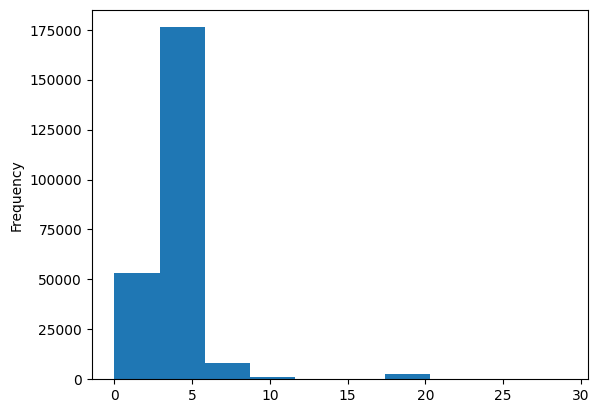

In [145]:
df.loc[df.beds < res[0.95]].beds.plot(kind='hist')

In [146]:
df.loc[df.beds < res[0.95]].beds.max()

29.0

<AxesSubplot: ylabel='Frequency'>

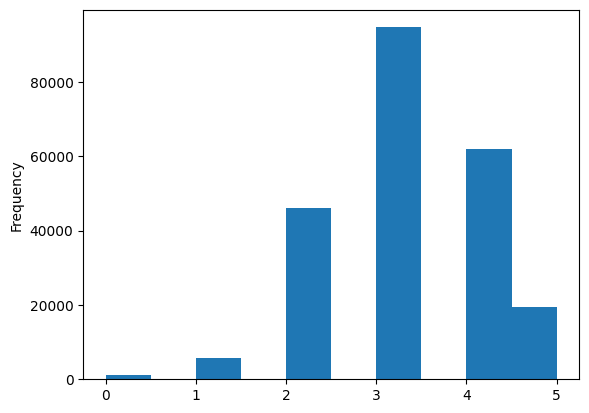

In [147]:
df.loc[df.beds < res[0.90]].beds.plot(kind='hist')

In [148]:
df.loc[df.beds >= res[0.95], 'beds'] = np.NaN

In [149]:
df.beds.value_counts()

3.0     94740
4.0     62036
2.0     46166
5.0     19458
6.0      5659
1.0      5613
20.0     2424
7.0      1487
0.0      1218
8.0      1039
10.0      670
9.0       429
12.0      178
11.0      112
16.0       65
13.0       43
14.0       40
15.0       29
18.0       28
24.0       26
17.0       10
22.0        8
26.0        7
28.0        6
19.0        6
27.0        4
23.0        3
25.0        2
29.0        1
21.0        1
Name: beds, dtype: int64

In [150]:
df.beds.mode()

0    3.0
Name: beds, dtype: float64

In [151]:
df.isna().sum()

baths                  73358
city                       0
zipcode                    0
beds                   77247
state                      0
stories                99611
target                     0
Year built               542
Remodeled year         22849
Heating                  542
Cooling                  542
Parking                  542
lotsize                24667
private_pool               0
sqft_replaced           4864
type                       0
recovered_stories     311412
new_status                 0
new_fireplace              0
schoolsLen                 0
number_of_school           0
max_school_rating       2537
mean_school_rating      2537
min_school_dist         2613
mean_school_dist        2613
num_of_classes             0
dtype: int64

### Обработаем stories

In [152]:
df.stories.value_counts()

1.0                                  64801
2.0                                  53773
1                                    22568
2                                    17685
3.0                                  10868
                                     ...  
4.0000                                   1
1.2                                      1
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
50.0                                     1
Name: stories, Length: 333, dtype: int64

In [154]:
# df.stories = df.stories.str.lower()

# df.stories = df.stories.fillna('unknown')

# stories_dict = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9}

# df['new_stories'] = None
# for  i in stories_dict:
#     df.new_stories[df.stories.str.contains(i)] = stories_dict[i]

# df.stories = df.stories.str.replace(r'[^0-9]', '', regex=True)
# df.stories[df.stories == ''] = np.NaN

# df.stories = df.stories.astype('float')

# df.stories[df.stories > 100] = np.NaN

# df.stories[df.stories  == 0] = np.NaN

# df.stories.isna().sum()

# df.new_stories = np.where(df.stories.notna(), df.stories, df.new_stories)

# df.new_stories.isna().sum()

# df[df.recovered_stories.notna() & df.new_stories.isna()]

Обработака stories не дала результата, слишком много пропусков остается

In [153]:
df.drop(['stories', 
         'recovered_stories', 
#          'new_stories'
        ], axis=1, inplace=True)

### Обработаем года постройки

In [155]:
df['Year built'].value_counts()

2019    31598
        17562
2006     7848
2005     7336
2007     6943
        ...  
1809        1
1799        1
1823        1
1807        1
1804        1
Name: Year built, Length: 226, dtype: int64

In [156]:
df['Year built'][df['Year built'] == ''] = None
df['Year built'][df['Year built'] == 'No Data'] = 0
df['Year built'][df['Year built'].isna()] = 0
df['Year built'] = df['Year built'].astype('int64')
df['Year built'][df['Year built'] == 0] = np.NaN

In [157]:
df['Year built'].min() # явно выброс

1019.0

In [158]:
df['Year built'].max() # тоже выброс

559990649990.0

In [159]:
df['Year built'][df['Year built'] < 1600] = np.NaN # уберем неправдопобные значения
df['Year built'][df['Year built'] > 2025] = np.NaN
df = df[~(df['Year built'] == 2025)]
df.reset_index(drop=True, inplace=True)
df['Year built'][df['Year built'].isna()] = 0
df['Year built'] = df['Year built'].astype('int64')

Обраюотаем так же год переделки

In [161]:
df['Remodeled year'].value_counts()

        151399
2006      5422
2005      4675
2007      4245
2008      3647
         ...  
1870         1
1853         1
1888         1
1874         1
1862         1
Name: Remodeled year, Length: 148, dtype: int64

In [162]:
df['Remodeled year'][df['Remodeled year'] == ''] = np.NaN
df['Remodeled year'] = df['Remodeled year'].astype('float')
df['Remodeled year'][df['Remodeled year'] == 0] = np.NaN
df['Remodeled year'].min()

1853.0

In [163]:
df['Remodeled year'].max()

2021.0

Обработаем нестыковки Remodeled year и Year built

In [164]:
df['Remodeled year'][df['Remodeled year'].isna()] = 0
df['Remodeled year'] = df['Remodeled year'].astype('int64')

In [166]:
df[df['Remodeled year'] > df['Year built']]

,baths,city,zipcode,beds,state,target,Year built,Remodeled year,Heating,Cooling,...,type,new_status,new_fireplace,schoolsLen,number_of_school,max_school_rating,mean_school_rating,min_school_dist,mean_school_dist,num_of_classes
2,2.0,los angeles,90049,3.0,CA,2895000.0,1961,1967,Forced Air,Central,...,single family,for sale,1.0,1,3.0,8.0,6.67,1.19,1.96,13
10,3.0,pembroke pines,33028,4.0,FL,525000.0,1996,1997,Forced Air,Central,...,single family,for sale,0.0,1,3.0,8.0,7.33,0.92,2.04,14
13,NaN,fort lauderdale,33311,NaN,FL,335000.0,2008,2009,,,...,another,for sale,0.0,1,4.0,4.0,1.75,0.50,0.70,14
14,NaN,new york,10027,NaN,NY,2650000.0,1899,2007,,,...,townhouse,for sale,0.0,1,4.0,5.0,2.50,0.10,0.50,14
22,7.0,washington,20009,8.0,DC,3749000.0,1915,2009,Radiant,Central,...,single family,for sale,1.0,1,2.0,10.0,6.50,0.14,0.52,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318738,NaN,gainesville,32641,3.0,FL,110000.0,1945,2019,Other,,...,single family,for sale,0.0,1,3.0,6.0,4.00,1.83,2.73,12
318741,2.0,sunrise,33313,3.0,FL,287999.0,1969,1970,Forced air,Central,...,single family,for sale,0.0,1,3.0,6.0,4.00,0.10,0.83,14
318742,3.0,fairview park,44126,5.0,OH,384900.0,1950,2010,Forced Air,Central,...,single family,for sale,1.0,1,3.0,6.0,5.67,1.31,1.42,12
318743,NaN,san antonio,78212,2.0,TX,799500.0,1938,1980,Wall,Central,...,single family,for sale,0.0,1,3.0,5.0,4.00,0.25,1.31,14


In [167]:
df['temp'] = df[(df['Year built'] >= df['Remodeled year']) & (df['Remodeled year'] != 0)]['Year built']
df['Year built'][df.temp.notna()] = df['Remodeled year'][df.temp.notna()]
df['Remodeled year'][df.temp.notna()] = df.temp[df.temp.notna()]
df.drop('temp', axis=1, inplace=True)

df['Remodeled year'][df['Remodeled year'] == 0] = df['Year built'][df['Remodeled year'] == 0]

### Обработаем heating

Сделаем признак бинарным, есть отопление и нет отопления

In [170]:
df.Heating = df.Heating.str.lower()

In [171]:
df.Heating.value_counts()

forced air                                                      129969
                                                                 64158
other                                                            27671
heat pump                                                         8684
no data                                                           8212
                                                                 ...  
central electric, wall heater                                        1
zoned heating, baseboard - hot water                                 1
central, exhaust fans, zoned                                         1
central air, wall unit(s)                                            1
baseboard, hot water, programmable thermostat, radiant floor         1
Name: Heating, Length: 1886, dtype: int64

In [172]:
df['Heating'] = df['Heating'].fillna('no data')
df['Heating'][df['Heating'] == ''] = 'no data'
df['Heating'][df['Heating'] == 'no data'] = 0
df['Heating'][df['Heating'] != 0] = 1

df['Heating'].value_counts()

1    245841
0     72912
Name: Heating, dtype: int64

### Обработаем cooling

Сделаем призник бинарным, есть охлаждение и нет охлаждения.

In [173]:
df.Cooling = df.Cooling.str.lower()
df.Cooling.value_counts()[:20]

central                                            154339
                                                    72414
central air                                         14365
no data                                             10200
has cooling                                          8771
none                                                 6882
central electric                                     6132
wall                                                 3891
central gas                                          3551
central heating                                      2799
cooling system                                       2689
central a/c                                          2005
other                                                1739
central a/c (electric), central heat (gas)           1640
central a/c (electric), central heat (electric)      1427
central, electric                                    1059
refrigeration                                        1059
electric      

In [174]:
df.Cooling[df.Cooling.isna()] = 'no data'
df.Cooling[df.Cooling == ''] = 'no data'
df.Cooling[df.Cooling == 'none'] = 'no data'
df.Cooling[df.Cooling == 'no data'] = 0
df.Cooling[df.Cooling != 0] = 1

df.Cooling.value_counts()

1    228715
0     90038
Name: Cooling, dtype: int64

### Обработаем parking

Сделаем признак бинарным, есть парковка и нет парковки

In [175]:
df.Parking = df.Parking.str.lower()
df.Parking[df.Parking == ''] = 'no data'
df.Parking = df.Parking.fillna('no data')
df.Parking[df.Parking == 'none'] = 'no data'
df.Parking[df.Parking == '0'] = 'no data'
df.Parking[df.Parking == 'no data'] = 0
df.Parking[df.Parking != 0] = 1

df.Parking.value_counts()

1    179081
0    139672
Name: Parking, dtype: int64

### Обработаем lotsize

In [176]:
df.lotsize = df.lotsize.str.lower()
df.lotsize[df.lotsize == ''] = 0
df.lotsize[df.lotsize == 'no data'] = 0
df.lotsize = df.lotsize.fillna(0)
df.lotsize[df.lotsize == 0] = '0'

Встречаются значения в акрах, заменим их на квадратные футы

In [177]:
df['lotsize_mes'] = None
df['lotsize_mes'][df.lotsize.str.contains('acre')] = 1
df.lotsize[df['lotsize_mes'] == 1]

8              1.73 acres
17             1.18 acres
18        15.32 acres lot
28             0.28 acres
34         2.14 acres lot
               ...       
318735         0.32 acres
318736         1.09 acres
318737         0.81 acres
318738         0.28 acres
318739         0.47 acres
Name: lotsize, Length: 59128, dtype: object

In [178]:
df.lotsize.str.replace(r'[0-9]', '', regex=True).value_counts()

, sqft          94431
                93627
. acres         52103
, sq. ft.       23106
—               16927
 sqft           16033
, sqft lot      10947
. acres lot      5333
-- sqft lot      3758
 acre            1042
 sqft lot         466
 acres            355
 sq. ft.          327
 acre lot         139
 acres lot        130
, acres            19
,. acres            3
, acres lot         2
,. acres lot        2
,                   2
-                   1
Name: lotsize, dtype: int64

In [179]:
df['lotsize'] = df.lotsize.str.replace(r'[^.0-9]', '', regex=True)
df.lotsize[df.lotsize.str.endswith('..')] = df.lotsize[df.lotsize.str.endswith('..')].apply(lambda x: x[:-2])
df['lotsize'][df['lotsize'] == ''] = 0
df['lotsize'][df['lotsize'] == '.'] = 0
df['lotsize'] = df['lotsize'].astype('float')

In [184]:
df['lotsize'].value_counts()

0.00        81429
0.26         2932
6098.00      2542
7405.00      2506
0.28         2471
            ...  
28844.00        1
43037.00        1
21178.00        1
15094.00        1
2871.00         1
Name: lotsize, Length: 16127, dtype: int64

In [185]:
df['lotsize'][df['lotsize_mes'].isna() & (df['lotsize'] != 0)].max()

284621040.0

<AxesSubplot: ylabel='Frequency'>

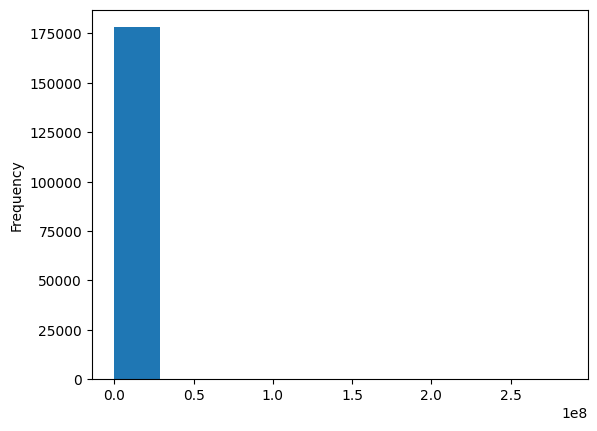

In [186]:
df['lotsize'][df['lotsize_mes'].isna() & (df['lotsize'] != 0)].plot(kind='hist')

In [188]:
(df['lotsize'][df['lotsize_mes'] == 1] * 43560).max()

2147483606.4

In [189]:
df['lotsize'][df['lotsize_mes'] == 1] = (df['lotsize'][df['lotsize_mes'] == 1] * 43560).round()

<AxesSubplot: ylabel='Frequency'>

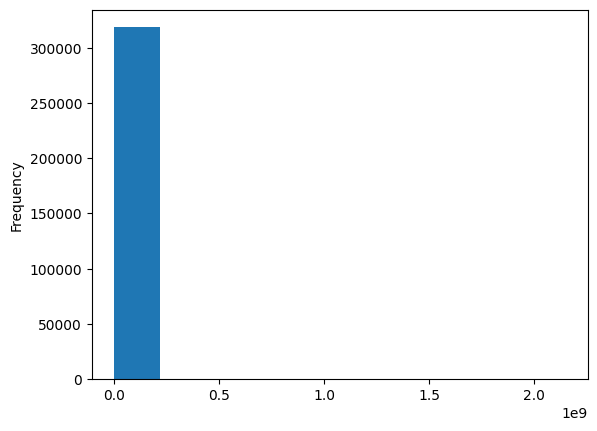

In [190]:
df['lotsize'].plot(kind='hist')

Обработаем слишком большие значения

In [191]:
res = df.lotsize.quantile([0.95, 0.99])

<AxesSubplot: ylabel='Frequency'>

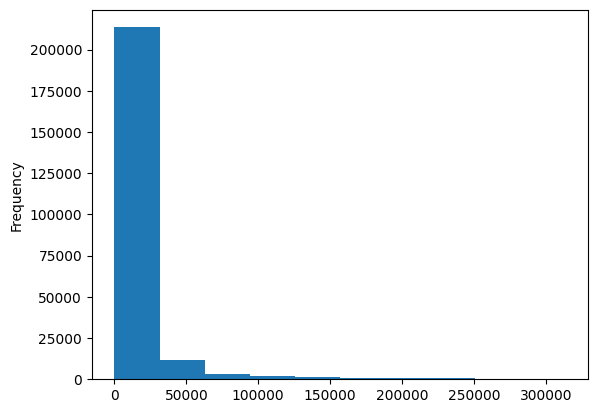

In [192]:
df['lotsize'][(df['lotsize'] < res[0.99]) & (df['lotsize'] != 0)].plot(kind='hist')

In [193]:
df.drop('lotsize_mes', axis=1, inplace=True)

In [194]:
df.isna().sum()

baths                 73356
city                      0
zipcode                   0
beds                  77245
state                     0
target                    0
Year built                0
Remodeled year            0
Heating                   0
Cooling                   0
Parking                   0
lotsize                   0
private_pool              0
sqft_replaced          4864
type                      0
new_status                0
new_fireplace             0
schoolsLen                0
number_of_school          0
max_school_rating      2537
mean_school_rating     2537
min_school_dist        2613
mean_school_dist       2613
num_of_classes            0
dtype: int64

### Заполним пропуски

In [195]:
beds_num = (df.sqft_replaced[(df.beds != 0) & (df.beds.notna())] / df.beds[(df.beds != 0) & (df.beds.notna())]).mean()

In [196]:
beds_num # средняя площадь на одну спальню

2478.3553681378794

In [197]:
bath_num = (df.sqft_replaced[(df.baths != 0) & (df.baths.notna())] / df.baths[(df.baths != 0) & (df.baths.notna())]).mean()

In [198]:
bath_num # средняя площадь на одну ванную, будем использовать среднее - 2500

2562.9113108275715

In [203]:
df.beds[df.beds == 0] = None
df.baths[df.baths == 0] = None
df.sqft_replaced[df.sqft_replaced == 0] = None

df = df[~((df.beds.isna()) & (df.baths.isna()) & (df.sqft_replaced.isna()))]

df.beds[(df.beds.isna()) & df.sqft_replaced.notna()] = df.sqft_replaced[
    (df.beds.isna()) & df.sqft_replaced.notna()].apply(fillna_beds)

df.baths[(df.baths.isna()) & df.sqft_replaced.notna()] = df.sqft_replaced[
    (df.baths.isna()) & df.sqft_replaced.notna()].apply(fillna_bath)

In [216]:
# заполним спальни и ванные с помощью друг друга
df.beds[df.beds.isna()] = df.baths[df.beds.isna()].round()

df.baths[df.baths.isna()] = df.beds[df.baths.isna()].round()

In [218]:
df.isna().sum()

baths                    0
city                     0
zipcode                  0
beds                     0
state                    0
target                   0
Year built               0
Remodeled year           0
Heating                  0
Cooling                  0
Parking                  0
lotsize                  0
private_pool             0
sqft_replaced         4089
type                     0
new_status               0
new_fireplace            0
schoolsLen               0
number_of_school         0
max_school_rating     2504
mean_school_rating    2504
min_school_dist       2580
mean_school_dist      2580
num_of_classes           0
dtype: int64

In [219]:
# заполним sqft с помощью baths
df.sqft_replaced[df.sqft_replaced.isna()] = df.baths[df.sqft_replaced.isna()] * 2500

In [220]:
df.isna().sum()

baths                    0
city                     0
zipcode                  0
beds                     0
state                    0
target                   0
Year built               0
Remodeled year           0
Heating                  0
Cooling                  0
Parking                  0
lotsize                  0
private_pool             0
sqft_replaced            0
type                     0
new_status               0
new_fireplace            0
schoolsLen               0
number_of_school         0
max_school_rating     2504
mean_school_rating    2504
min_school_dist       2580
mean_school_dist      2580
num_of_classes           0
dtype: int64

In [221]:
# Заполним характеристики школ
df.max_school_rating = df.max_school_rating.fillna(0)
df.mean_school_rating = df.mean_school_rating.fillna(0)

df.min_school_dist = df.min_school_dist.fillna(df.min_school_dist.max())
df.mean_school_dist = df.mean_school_dist.fillna(df.mean_school_dist.max())

In [223]:
df.isna().sum()

baths                 0
city                  0
zipcode               0
beds                  0
state                 0
target                0
Year built            0
Remodeled year        0
Heating               0
Cooling               0
Parking               0
lotsize               0
private_pool          0
sqft_replaced         0
type                  0
new_status            0
new_fireplace         0
schoolsLen            0
number_of_school      0
max_school_rating     0
mean_school_rating    0
min_school_dist       0
mean_school_dist      0
num_of_classes        0
dtype: int64

### Посмотрим корреляции

In [226]:
df[['Heating', 'Cooling', 'Parking', 'private_pool', 'num_of_classes']] = df[
    ['Heating', 'Cooling', 'Parking', 'private_pool', 'num_of_classes']].astype('int')

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317978 entries, 0 to 318752
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   baths               317978 non-null  float64
 1   city                317978 non-null  object 
 2   zipcode             317978 non-null  object 
 3   beds                317978 non-null  float64
 4   state               317978 non-null  object 
 5   target              317978 non-null  float64
 6   Year built          317978 non-null  int64  
 7   Remodeled year      317978 non-null  int64  
 8   Heating             317978 non-null  int32  
 9   Cooling             317978 non-null  int32  
 10  Parking             317978 non-null  int32  
 11  lotsize             317978 non-null  float64
 12  private_pool        317978 non-null  int32  
 13  sqft_replaced       317978 non-null  float64
 14  type                317978 non-null  object 
 15  new_status          317978 non-nul

In [228]:
df.corr()

,baths,beds,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,private_pool,sqft_replaced,new_fireplace,schoolsLen,number_of_school,max_school_rating,mean_school_rating,min_school_dist,mean_school_dist,num_of_classes
baths,1.000000,0.552286,0.348270,-0.046608,-0.047017,0.008747,-0.000272,0.198562,0.001872,0.145609,0.017203,0.110350,NaN,-0.026233,0.097488,0.161189,-0.005212,-0.006046,-0.038526
beds,0.552286,1.000000,0.143821,-0.044694,-0.045335,0.014060,-0.049761,0.182659,0.001969,0.057011,0.011366,0.054430,NaN,0.020977,-0.000837,0.032665,-0.010661,-0.011924,-0.040246
target,0.348270,0.143821,1.000000,0.022069,0.027324,-0.052430,-0.000643,0.039110,0.000681,0.156514,-0.001083,0.106830,NaN,-0.044289,0.223481,0.230865,0.029588,0.030152,-0.050470
Year built,-0.046608,-0.044694,0.022069,1.000000,0.993698,0.377912,0.338632,0.223117,0.001487,-0.021740,0.000305,0.137499,NaN,-0.005711,-0.004291,-0.012153,-0.006652,-0.006012,0.042012
Remodeled year,-0.047017,-0.045335,0.027324,0.993698,1.000000,0.378950,0.337795,0.223833,0.001428,-0.022368,0.000278,0.139069,NaN,-0.005918,-0.007116,-0.014316,-0.006504,-0.005907,0.040763
Heating,0.008747,0.014060,-0.052430,0.377912,0.378950,1.000000,0.583186,0.369327,0.001128,0.069055,0.000808,0.151977,NaN,0.005818,-0.053284,-0.033394,-0.023340,-0.022189,0.063637
Cooling,-0.000272,-0.049761,-0.000643,0.338632,0.337795,0.583186,1.000000,0.245887,-0.002893,0.096206,0.001111,0.135939,NaN,-0.015381,0.076648,0.047592,-0.011722,-0.010011,0.114924
Parking,0.198562,0.182659,0.039110,0.223117,0.223833,0.369327,0.245887,1.000000,0.003064,0.157743,0.000199,0.179249,NaN,-0.013347,-0.001522,0.090605,-0.037428,-0.038116,0.017074
lotsize,0.001872,0.001969,0.000681,0.001487,0.001428,0.001128,-0.002893,0.003064,1.000000,-0.000083,0.000049,0.003791,NaN,-0.001606,-0.000472,0.000945,0.000114,0.000061,0.000401
private_pool,0.145609,0.057011,0.156514,-0.021740,-0.022368,0.069055,0.096206,0.157743,-0.000083,1.000000,-0.000868,0.037686,NaN,-0.028332,0.094205,0.166301,-0.017776,-0.016741,0.028678


min_school_dist и mean_school_dist имеют почти 100% кореляцию, удалим один из них сразу.

In [229]:
df.drop('mean_school_dist', axis=1, inplace=True)

df.reset_index(drop=True, inplace=True)

In [235]:
df.columns = ['baths', 'city', 'zipcode', 'beds', 'state', 'target', 'year_built',
       'remodeled_year', 'heating', 'cooling', 'parking', 'lotsize',
       'private_pool', 'sqft', 'type', 'status', 'fireplace',
       'number_of_school', 'max_school_rating', 'mean_school_rating',
       'min_school_dist', 'num_of_classes']

In [236]:
df[['city', 'zipcode', 'state', 'type']] = df[['city', 'zipcode', 'state', 'type']].astype('category')

In [237]:
df.status[df.status == 'for sale'] = 1
df.status[df.status != 1] = 0

In [238]:
df[['status', 'fireplace']] = df[['status', 'fireplace']].astype('int')

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317978 entries, 0 to 317977
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   baths               317978 non-null  float64 
 1   city                317978 non-null  category
 2   zipcode             317978 non-null  category
 3   beds                317978 non-null  float64 
 4   state               317978 non-null  category
 5   target              317978 non-null  float64 
 6   year_built          317978 non-null  int64   
 7   remodeled_year      317978 non-null  int64   
 8   heating             317978 non-null  int32   
 9   cooling             317978 non-null  int32   
 10  parking             317978 non-null  int32   
 11  lotsize             317978 non-null  float64 
 12  private_pool        317978 non-null  int32   
 13  sqft                317978 non-null  float64 
 14  type                317978 non-null  category
 15  status           

## Посмотрим на распределения получившихся переменных

In [241]:
cat_cols = ['city', 'zipcode', 'state', 'heating', 'cooling', 'parking',
       'private_pool', 'type', 'status', 'fireplace']

num_cols = df.columns.difference(cat_cols).to_list()

<AxesSubplot: >

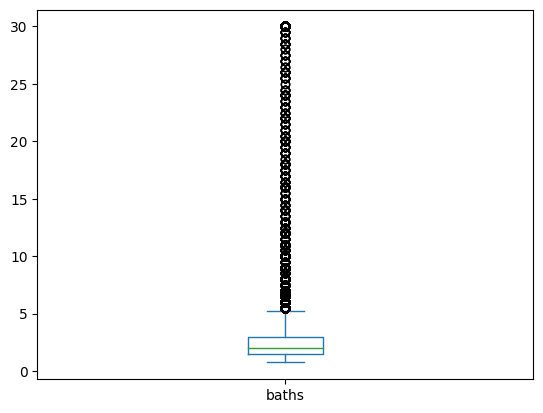

In [242]:
df.baths.plot(kind='box')

<AxesSubplot: >

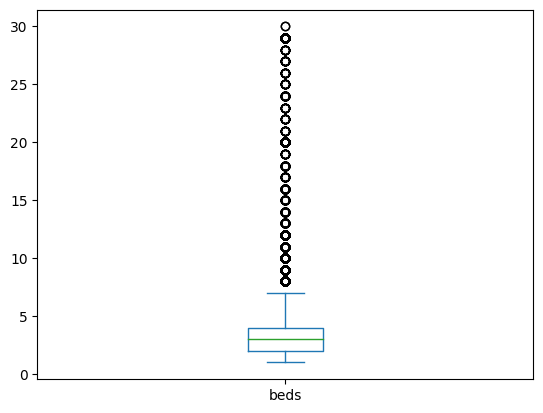

In [243]:
df.beds.plot(kind='box')

<AxesSubplot: >

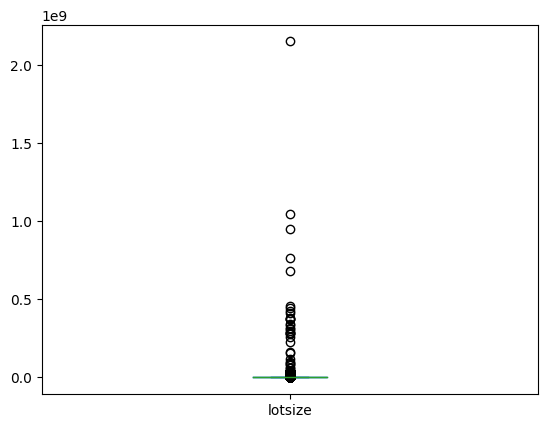

In [244]:
df.lotsize.plot(kind='box')

Обработаем слишком большие значения

In [249]:
df.lotsize.quantile(0.75) + iqr(df.lotsize) * 1.5

25125.0

In [250]:
df.lotsize.max()

2147483606.0

In [251]:
df.lotsize[df.lotsize > df.lotsize.quantile(0.75) + iqr(df.lotsize) * 1.5]

6         124582.0
8          75359.0
17         51401.0
18        667339.0
34         93218.0
            ...   
317948     43996.0
317951     44867.0
317952     49223.0
317961     47480.0
317962     35284.0
Name: lotsize, Length: 28181, dtype: float64

In [252]:
df.lotsize[df.lotsize > 100000] = 100000

<AxesSubplot: >

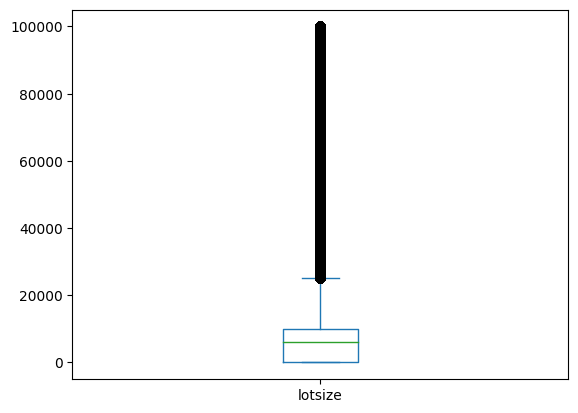

In [253]:
df.lotsize.plot(kind='box')

<AxesSubplot: >

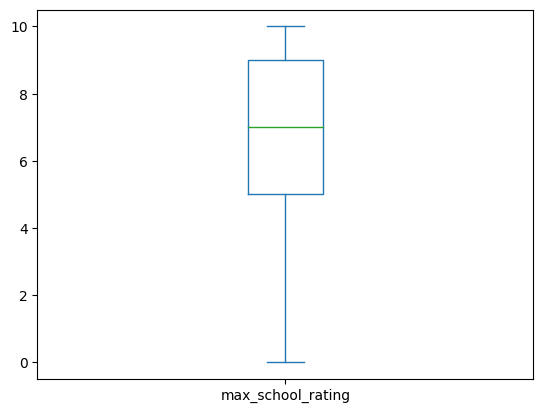

In [245]:
df.max_school_rating.plot(kind='box')

<AxesSubplot: >

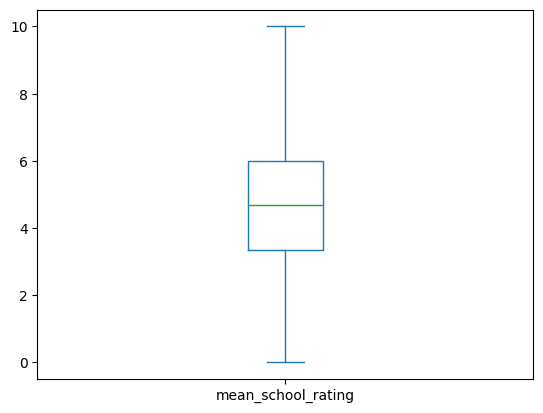

In [246]:
df.mean_school_rating.plot(kind='box')

<AxesSubplot: >

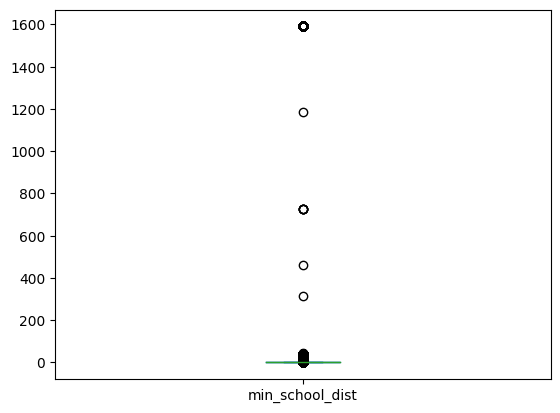

In [247]:
df.min_school_dist.plot(kind='box')

Заменим сначения расстояния более 100 на 100

In [257]:
df.min_school_dist[df.min_school_dist > 100] = 100

<AxesSubplot: >

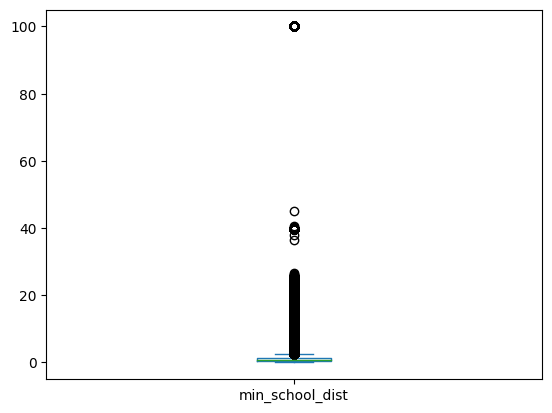

In [258]:
df.min_school_dist.plot(kind='box')

<AxesSubplot: >

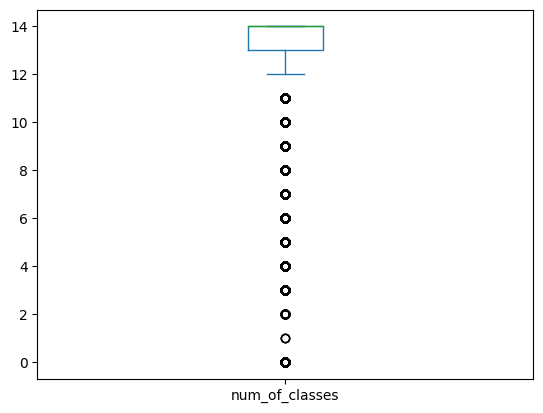

In [260]:
df.num_of_classes.plot(kind='box')

<AxesSubplot: >

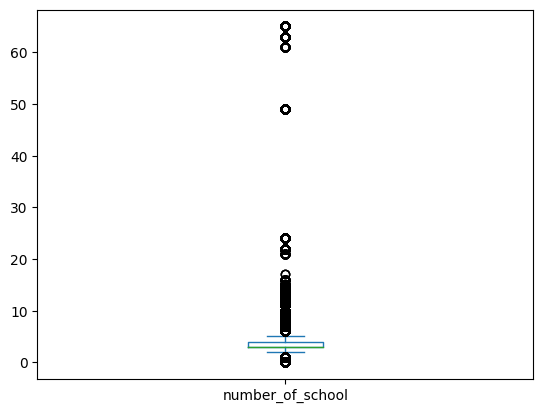

In [261]:
df.number_of_school.plot(kind='box')

<AxesSubplot: >

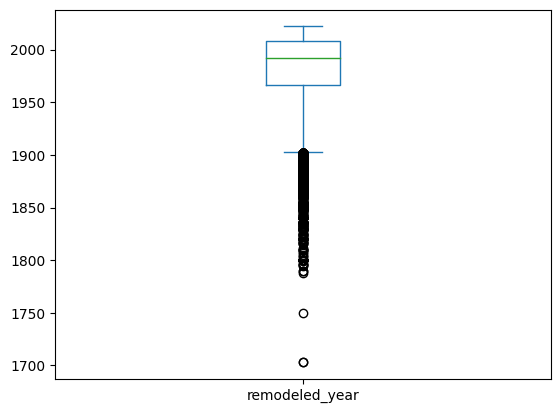

In [262]:
df.remodeled_year[df.remodeled_year != 0].plot(kind='box')

<AxesSubplot: >

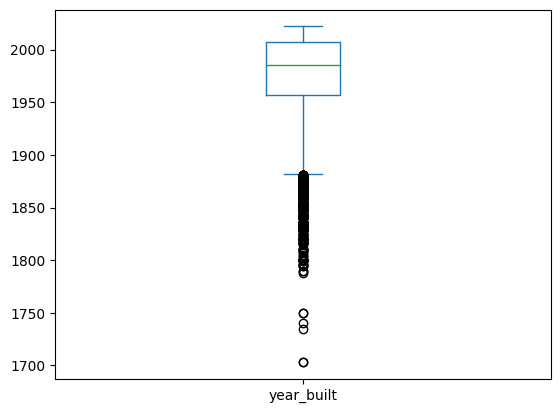

In [263]:
df.year_built[df.year_built != 0].plot(kind='box')

<AxesSubplot: >

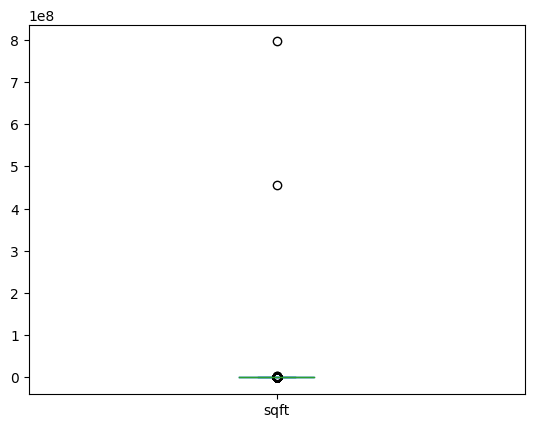

In [264]:
df.sqft.plot(kind='box')

Обработаем слишком большие значения

In [92]:
df.sqft[df.sqft > df.sqft.quantile(0.75) + iqr(df.sqft) * 1.5]

3           6457.0
18          5266.0
22          5796.0
39          5358.0
46          5000.0
            ...   
317879      5621.0
317883    409538.0
317916      4860.0
317921      5000.0
317962      5992.0
Name: sqft, Length: 18464, dtype: float64

In [93]:
df.sqft.quantile(0.75) + iqr(df.sqft) * 1.5

4647.0

In [109]:
df.sqft.quantile(0.99)

9222.689999999944

In [111]:
df[(df.sqft > 10000)]

,baths,city,zipcode,beds,state,target,year_built,remodeled_year,heating,cooling,...,sqft,type,status,fireplace,number_of_school,max_school_rating,mean_school_rating,min_school_dist,num_of_classes,price_per_ft
75,2.0,kew gardens,11415,2.0,NY,319000.0,1969,0,0,0,...,107250.0,condo,1,0,3.0,7.0,5.33,0.37,13,2.974359
116,30.0,bayside,11361,29.0,NY,270000.0,1963,0,1,0,...,109200.0,single family,1,0,3.0,10.0,8.00,0.51,13,2.472527
174,30.0,new york,10031,29.0,NY,455000.0,1957,0,0,0,...,225667.0,condo,1,0,3.0,2.0,1.67,0.48,10,2.016245
269,30.0,bayside,11360,29.0,NY,239000.0,1961,0,1,0,...,373772.0,condo,1,0,3.0,9.0,7.67,0.27,7,0.639427
333,28.0,forest hills,11375,29.0,NY,440000.0,1939,0,0,0,...,71838.0,condo,1,0,3.0,10.0,7.67,0.26,14,6.124892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317573,16.0,brooklyn,11215,16.0,NY,245000.0,1920,0,0,0,...,40558.0,condo,1,0,1.0,10.0,10.00,0.19,6,6.040732
317639,1.0,new york,10011,1.0,NY,499000.0,1920,0,0,0,...,21304.0,condo,1,0,3.0,8.0,6.00,0.10,14,23.422831
317823,5.0,pinecrest,33156,5.0,FL,2895000.0,2016,0,0,1,...,12500.0,single family,0,0,2.0,10.0,8.00,1.70,14,231.600000
317858,20.0,detroit,48228,6.0,MI,749000.0,1956,0,1,0,...,13870.0,multi family,1,0,13.0,6.0,3.08,1.18,13,54.001442


<AxesSubplot: >

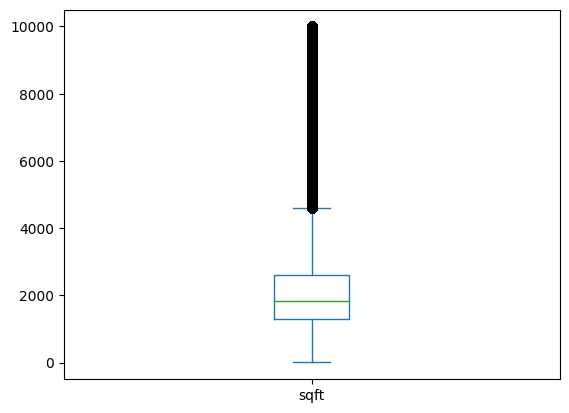

In [265]:
df[~(df.sqft > 10000)].sqft.plot(kind='box')

Удалим слишком большие и слишком малые значения стоимости за квадратный фут

In [266]:
df['price_per_ft'] = df.target / df.sqft

<AxesSubplot: >

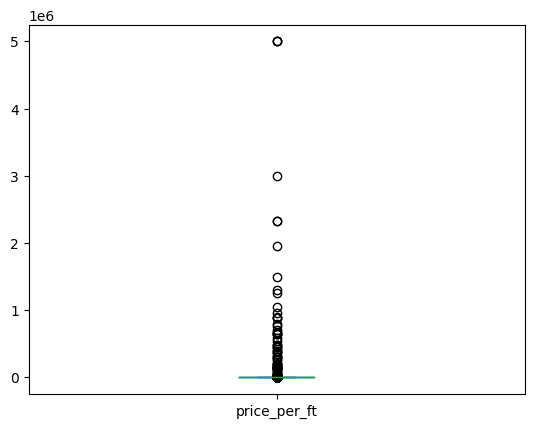

In [267]:
df.price_per_ft.plot(kind='box')

In [268]:
df.price_per_ft.quantile(0.95)

683.2011517656637

<AxesSubplot: >

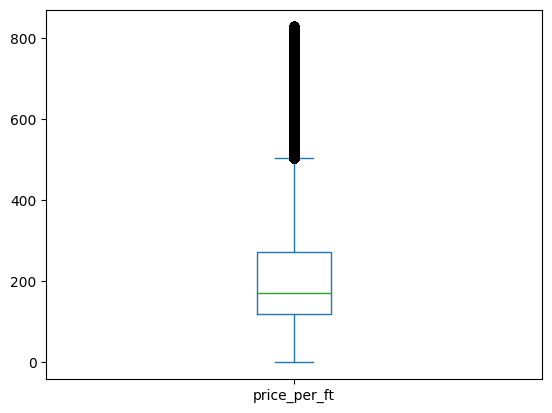

In [269]:
df[~(df.price_per_ft > df.price_per_ft.quantile(0.97))].price_per_ft.plot(kind='box')

<AxesSubplot: >

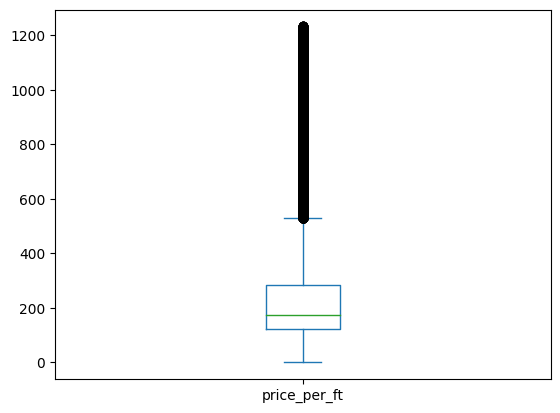

In [270]:
df[~(df.price_per_ft > df.price_per_ft.quantile(0.99))].price_per_ft.plot(kind='box')

In [271]:
df = df[~(df.price_per_ft > df.price_per_ft.quantile(0.97))]

In [272]:
df.price_per_ft.quantile(0.03)

44.43046912505726

In [273]:
df = df[~(df.price_per_ft < df.price_per_ft.quantile(0.01))]
df.drop('price_per_ft', axis=1, inplace=True)

<AxesSubplot: >

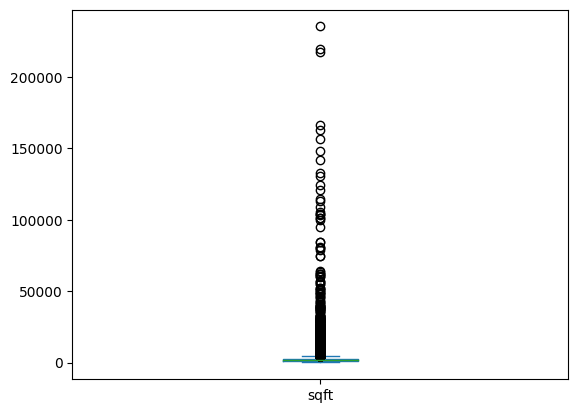

In [275]:
df.sqft.plot(kind='box')

In [276]:
df.sqft.quantile(0.01)

597.5300000000002

In [277]:
df.sqft.min()

100.0

Удалим слишком маленькую площадь

In [278]:
df = df[~(df.sqft < 200)]

<AxesSubplot: >

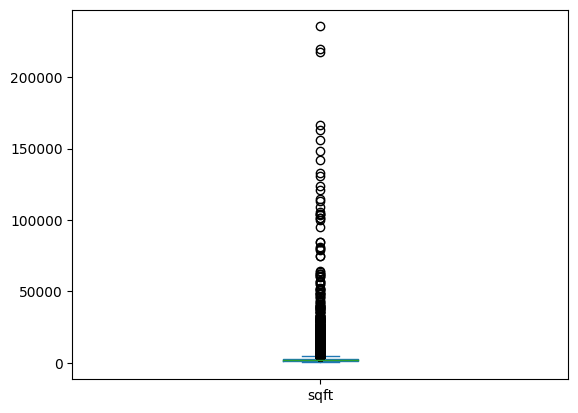

In [279]:
df.sqft.plot(kind='box')

<AxesSubplot: >

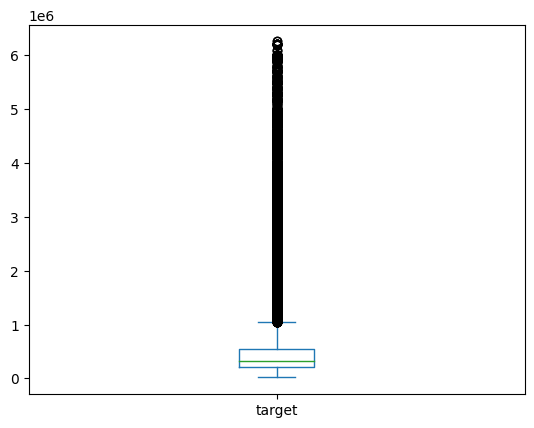

In [281]:
df.target.plot(kind='box')

In [282]:
df.reset_index(drop=True, inplace=True)

<AxesSubplot: >

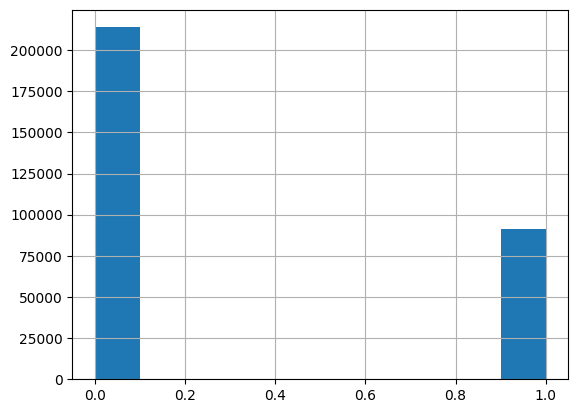

In [284]:
df.fireplace.hist()

<AxesSubplot: >

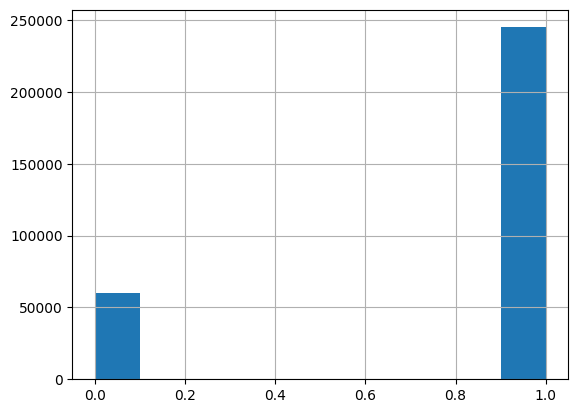

In [287]:
df.status.hist()

<AxesSubplot: >

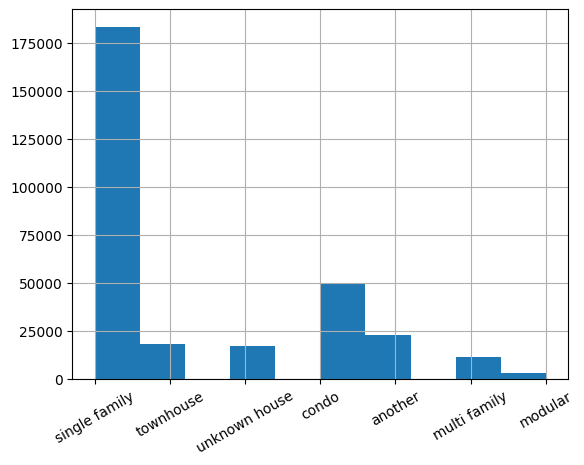

In [289]:
df.type.hist(xrot=30)

<AxesSubplot: >

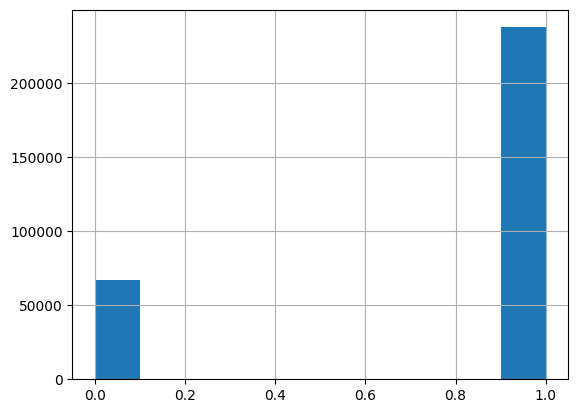

In [292]:
df.heating.hist()

<AxesSubplot: >

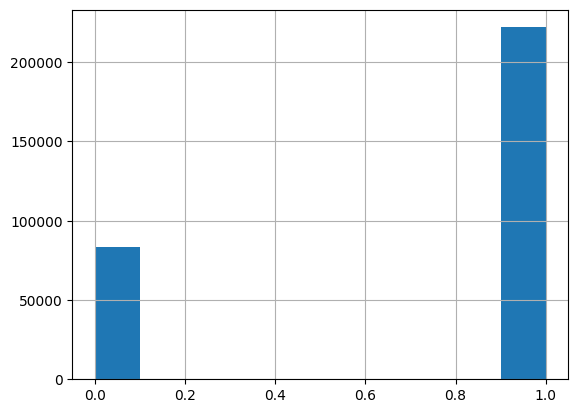

In [294]:
df.cooling.hist()

<AxesSubplot: >

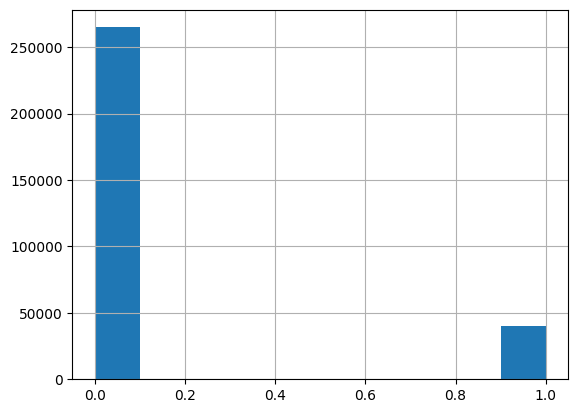

In [296]:
df.private_pool.hist()

<AxesSubplot: >

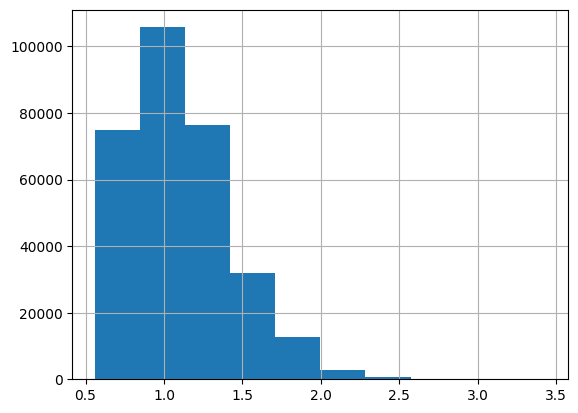

In [311]:
get_log_column('baths').hist()

<AxesSubplot: >

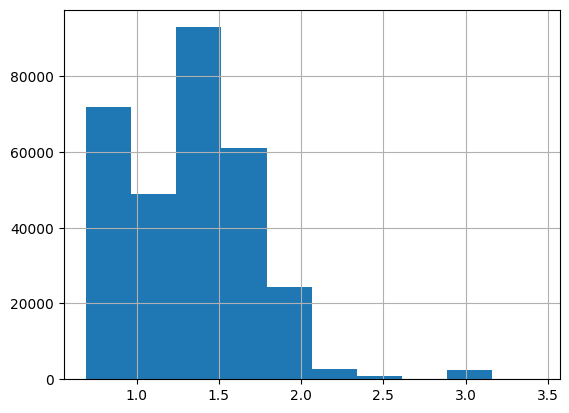

In [313]:
get_log_column('beds').hist()

<AxesSubplot: >

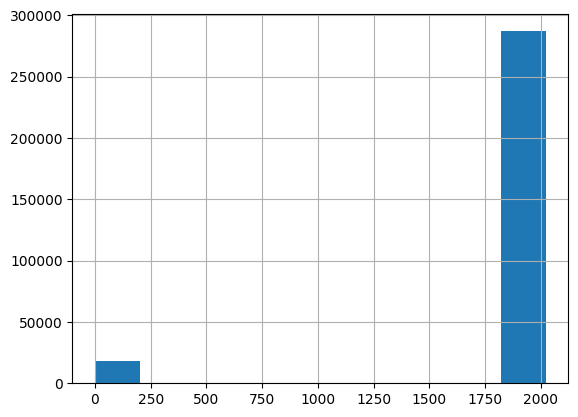

In [326]:
df.year_built.hist()

Не удачная идея заменить пропуски в year_built нулями, заменим медианным значением

In [328]:
df[df.year_built == 0]

,baths,city,zipcode,beds,state,target,year_built,remodeled_year,heating,cooling,...,private_pool,sqft,type,status,fireplace,number_of_school,max_school_rating,mean_school_rating,min_school_dist,num_of_classes
22,3.0,houston,77018,3.0,tx,499900.0,0,0,0,0,...,0,2575.0,single family,1,0,3.0,9.0,6.00,0.24,14
44,2.5,durham,27713,3.0,nc,259658.0,0,0,0,0,...,0,1681.0,townhouse,1,0,3.0,4.0,3.33,0.84,14
46,2.0,temple terrace,33637,3.0,fl,244990.0,0,0,0,0,...,0,1504.0,single family,1,0,3.0,3.0,2.33,2.69,14
64,3.0,spring,77386,4.0,tx,299999.0,0,0,0,0,...,0,2265.0,single family,1,0,3.0,9.0,8.67,1.07,10
70,2.0,port charlotte,33953,3.0,fl,235900.0,0,0,0,0,...,0,1702.0,single family,1,0,8.0,6.0,2.00,1.90,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305121,2.5,tampa,33625,3.0,fl,327990.0,0,0,0,0,...,1,2262.0,townhouse,1,0,3.0,6.0,5.33,0.88,13
305169,2.5,murfreesboro,37127,3.0,tn,231100.0,0,0,0,0,...,0,1566.0,townhouse,1,0,3.0,8.0,6.33,2.22,13
305239,2.5,north richland hills,76182,2.0,tx,325000.0,0,0,0,0,...,0,1925.0,townhouse,1,0,3.0,10.0,8.67,0.39,14
305257,3.5,san antonio,78260,4.0,tx,445981.0,0,0,0,0,...,1,2754.0,single family,1,0,3.0,10.0,8.67,25.04,14


In [329]:
df.year_built[df.year_built != 0].mean()

1980.2781699828993

In [330]:
df.year_built[df.year_built != 0].median()

1986.0

In [331]:
df.year_built[df.year_built != 0].mode()

0    2019
Name: year_built, dtype: int64

In [332]:
df.year_built[df.year_built == 0] = int(df.year_built[df.year_built != 0].median())

<AxesSubplot: >

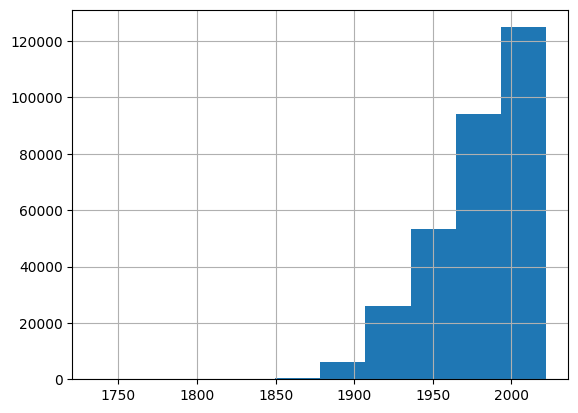

In [333]:
df.year_built.hist()

In [337]:
# remodeled_year равные нулу заменим значением year_built
df.remodeled_year[df.remodeled_year == 0] = df.year_built[df.remodeled_year == 0]

<AxesSubplot: >

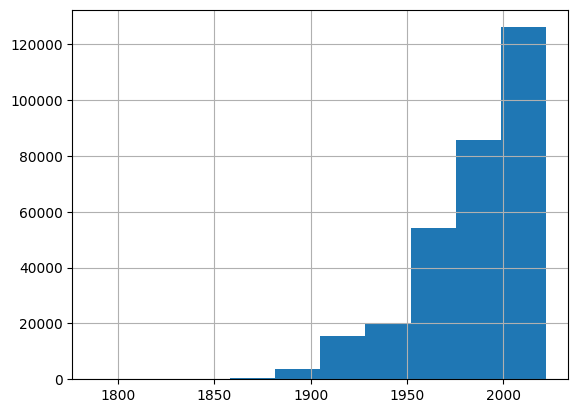

In [338]:
df.remodeled_year.hist()

<AxesSubplot: >

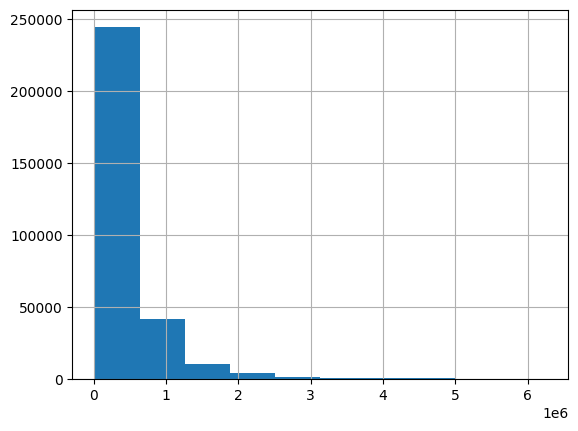

In [342]:
df.target.hist()

У таргета распределение сильно смещено влево, надо посмотреть рапределение логарифмированного таргета

<AxesSubplot: >

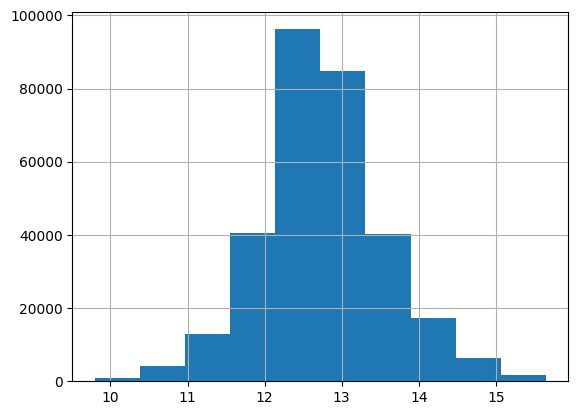

In [343]:
get_log_column('target').hist()

Распределение близко к нормальному, надо будет попробовать использовать логарифмированный таргет для обучения

## Посмотрим значимость переменных

In [5]:
df.baths = df.baths * 2 # умножим на два baths что бы значения были целыми

df.state = df.state.str.lower()

In [347]:
df[['baths', 'beds', 'max_school_rating', 'number_of_school']] = df[['baths', 'beds', 'max_school_rating', 'number_of_school']].astype('int')

In [348]:
category = ['city', 'zipcode', 'state', 'heating', 'cooling', 'parking',
       'private_pool', 'type', 'status', 'fireplace']

num_cols = df.columns.difference(category).to_list()

discrete = ['baths', 'beds', 'max_school_rating', 'number_of_school', 'num_of_classes', 'remodeled_year', 'year_built']

continuous = list(set(num_cols).difference(discrete))

bin_cols = ['heating', 'cooling', 'parking', 'private_pool', 'status', 'fireplace']

cat_cols = list(set(category).difference(bin_cols))

In [349]:
continuous_test = continuous.copy()
continuous_test.remove('target')

<AxesSubplot: >

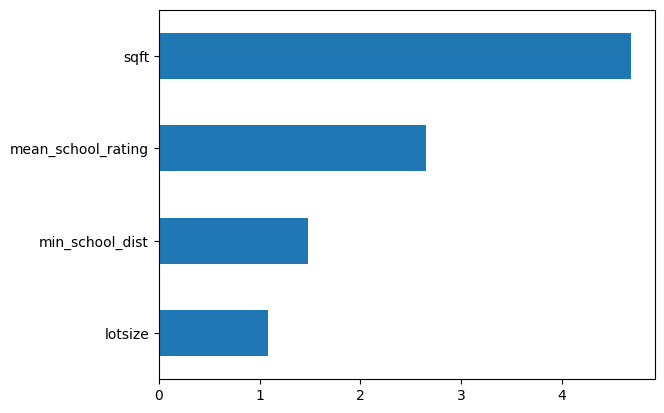

In [350]:
imp_num = pd.Series(f_classif(df[continuous_test], df.target)[0], index = continuous_test)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Почти все непрерывные переменные имеют весомую значимость

In [351]:
df_copy = df.copy()

df = df_copy

df.to_pickle('data_for_feat_sel.pkl')

label_encoder = LabelEncoder()
for col in cat_cols:
    df[col] = pd.Series(label_encoder.fit_transform(df[col]))

<AxesSubplot: >

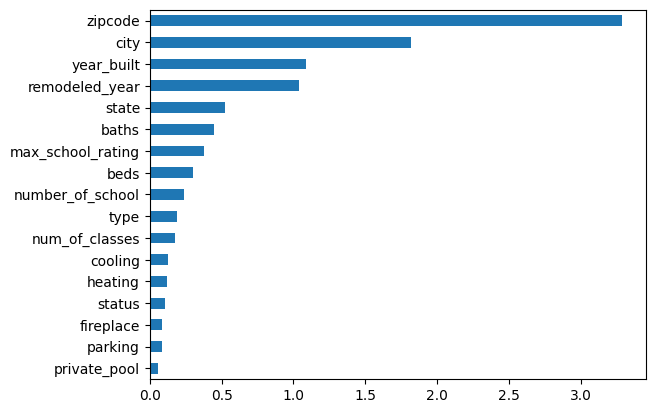

In [353]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols + discrete], df.target,
                                     discrete_features =True), index = bin_cols + cat_cols + discrete)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Есть признаки с низкой значимость, далее попробуем их отсеить.

## Обучим наивную модель

In [354]:
X = df.drop('target', axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED)

In [355]:
reg = LinearRegression()
reg.fit(X_train, y_train)
predict = reg.predict(X_val)
print(f"Точность наивной модели по метрике MAPE: {(mape(y_val, predict))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 71.27%


Точность оставляет желать лучшего, попробуем более совершеннкю модель. Попробую catboost, потому что это современная модель, с хорошей точностью на стандартных настройках, так де умеет обрабатывать категориальные признаки без кодирования.

## Подбор лушей модели

### Catboost

In [105]:
%%time
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          task_type="GPU",
                          eval_metric='MAPE',
#                           boosting_type='Ordered',
                          custom_metric=['R2', 'MAE'],
                          silent=True
                         )
model.fit(X_train, y_train,
         cat_features=cat_cols + bin_cols,
         eval_set=(X_val, y_val),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE, R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


CPU times: total: 6min 53s
Wall time: 4min 59s


In [106]:
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 22.35%


Точность уже намного лучше, посмотрим результат с логарифмированным таргетом

In [24]:
%%time
model = CatBoostRegressor(iterations = 5000,
                          learning_rate=0.1,
#                           depth=1,
                          random_seed = RANDOM_SEED,
                          task_type="GPU",
                          eval_metric='MAPE',
                          boosting_type='Ordered',
                          custom_metric=['R2', 'MAE'],
                          silent=True
                         )
model.fit(X_train, np.log(y_train),
         cat_features=cat_cols + bin_cols,
         eval_set=(X_val, np.log(y_val)),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE, R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


CPU times: total: 10min 10s
Wall time: 7min 37s


In [25]:
predict = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 19.41%


Результат лучше, далее будем использовать логарифмированный таргет.

Попробуем упростить модель, ограничив глубину деревьев

In [28]:
%%time
model = CatBoostRegressor(iterations = 5000,
                          learning_rate=0.1,
                          depth=10,
                          random_seed = RANDOM_SEED,
                          task_type="GPU",
                          eval_metric='MAPE',
                          boosting_type='Ordered',
                          custom_metric=['R2', 'MAE'],
                          silent=True
                         )
model.fit(X_train, np.log(y_train),
         cat_features=cat_cols + bin_cols,
         eval_set=(X_val, np.log(y_val)),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE, R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


CPU times: total: 18min 59s
Wall time: 14min 42s


In [29]:
predict = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 18.67%


Результат немного лучше, возможно слишком сложная модель для такой задачи. Попробуем random forest

### Random forest

In [20]:
random_forest = RandomForestRegressor(
    n_estimators=100,
    n_jobs=-1,
    max_features=20,#int(np.sqrt(len(X_train.columns))),
    max_depth=50,
    random_state=RANDOM_SEED)
#print("Random Forest:", estimate_accuracy(random_forest, X, y))

In [21]:
%%time
random_forest.fit(X_train,np.log(y_train))

CPU times: total: 6min 39s
Wall time: 1min


RandomForestRegressor(max_depth=50, max_features=20, n_jobs=-1, random_state=42)

In [22]:
predict_test = np.exp(random_forest.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 19.24%


Результат не сильно хуже, посмотрим, что можно выжать из случайного леса

## Feature engineering

Попробуем получить признаки на основе географического положения

In [382]:
df.groupby('city').target.mean()

city
                        NaN
--                      NaN
abilene       266025.984962
abingdon      374542.406250
accokeek      356600.000000
                  ...      
youngstown     52672.482759
youngtown     210316.000000
yuba city     325535.704545
zanesville    330475.000000
zionsville    437900.555556
Name: target, Length: 1732, dtype: float64

In [383]:
df['price_per_sqft'] = df.target / df.sqft

In [384]:
city = df.groupby('city').agg({'price_per_sqft': 'mean', 'sqft': 'mean', 'city': 'count'})

In [385]:
city

,price_per_sqft,sqft,city
city,,,
,NaN,NaN,0
--,NaN,NaN,0
abilene,110.886491,2281.120301,133
abingdon,128.350629,2787.921875,64
accokeek,262.158315,2180.000000,3
...,...,...,...
youngstown,37.938040,1379.172414,29
youngtown,119.077696,2103.250000,8
yuba city,170.195569,2046.454545,44


In [391]:
city.to_pickle('city.pkl')

In [386]:
city.loc[df.city[2], 'price_per_sqft'].round()

224.0

Добавим признаки средняя цена, средняя площадь и среднее количество недвижимости по городу

In [387]:
df['city_mean_price'] = df.city.apply(lambda x: city.loc[x, 'price_per_sqft'].round())
df['city_mean_sqft'] = df.city.apply(lambda x: city.loc[x, 'sqft'].round())
df['city_prop_count'] = df.city.apply(lambda x: city.loc[x, 'city'].round())

Добавим такие же признаки по каждому штату

In [389]:
state = df.groupby('state').agg({'price_per_sqft': 'mean', 'sqft': 'mean', 'state': 'count'})

In [390]:
state

,price_per_sqft,sqft,state
state,,,
az,156.606285,2137.908108,3145
ca,399.060935,2218.672216,18982
co,264.469617,2269.673982,6015
dc,452.844098,1879.028262,4069
de,355.497015,1281.600000,5
fl,228.682389,1976.407962,92766
ga,198.576357,2513.423970,5682
ia,107.673756,1843.934010,197
il,204.890038,2264.885386,7486


In [392]:
state.to_pickle('state.pkl')

In [393]:
df['state_mean_price'] = df.state.apply(lambda x: state.loc[x, 'price_per_sqft'].round())
df['state_mean_sqft'] = df.state.apply(lambda x: state.loc[x, 'sqft'].round())
df['state_prop_count'] = df.state.apply(lambda x: state.loc[x, 'state'].round())

Добавим признаки по почтовому индексу - среднее количество спален, среднее количество спален, средний год постройки, доля домов с отоплением, кондиционированием и каминами, среднее количество школ, средний рейтинг школ, средняя цена квадратного фута, средняя площадь и количество недвижимости в каждом почтовом индексе

Удалим недвижимость с ошибками в индексах

In [398]:
df = df[~(df.zipcode == '00000')]

In [399]:
df = df[~(df.zipcode == '--')]

In [400]:
zipcode = df.groupby('zipcode').agg({'baths': 'mean', 'beds': 'mean', 'year_built': 'mean', 'heating': 'mean', 
                                     'cooling': 'mean', 'fireplace': 'mean', 'number_of_school': 'mean', 
                                     'mean_school_rating': 'mean', 'price_per_sqft': 'mean', 'sqft': 'mean', 
                                     'zipcode': 'count'})

In [401]:
zipcode.iloc[:60]

,baths,beds,year_built,heating,cooling,fireplace,number_of_school,mean_school_rating,price_per_sqft,sqft,zipcode
zipcode,,,,,,,,,,,
--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
02108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
02109,3.600000,2.000000,1927.200000,1.000000,0.800000,0.400000,2.000000,2.900000,733.983657,1360.000000,5
02110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
02111,3.600000,1.600000,1966.200000,1.000000,1.000000,0.000000,2.000000,4.000000,675.041862,1267.600000,5
02113,2.666667,2.000000,1894.333333,1.000000,1.000000,0.333333,2.000000,3.000000,731.872052,1207.000000,3
02114,2.888889,1.666667,1967.111111,0.888889,0.777778,0.000000,1.888889,3.055556,614.345904,1047.888889,9
02115,2.000000,3.000000,1915.000000,1.000000,0.500000,0.000000,2.000000,5.500000,565.631231,1210.000000,2


In [403]:
zipcode.to_pickle('zipcode.pkl')

In [404]:
df['zip_mean_price'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'price_per_sqft'].round())
df['zip_mean_sqft'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'sqft'].round())
df['zip_prop_count'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'zipcode'].round())
df['zip_baths_mean'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'baths'].round(1))
df['zip_beads_mean'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'beds'].round())
df['zip_year_bilt_mean'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'year_built'].round())
df['zip_heating_mean'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'heating'].round(2))
df['zip_cooling_mean'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'cooling'].round(2))
df['zip_fireplace_mean'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'fireplace'].round(2))
df['zip_school_rating_mean'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'mean_school_rating'].round(2))
df['zip_number_of_school_mean'] = df.zipcode.apply(lambda x: zipcode.loc[x, 'number_of_school'].round(2))

In [405]:
df.drop('price_per_sqft', axis=1, inplace=True)

In [423]:
df[['heating', 'cooling', 'parking', 'private_pool', 'status', 'fireplace']] = df[['heating', 'cooling', 'parking', 'private_pool', 'status', 'fireplace']].astype('int')

### Обучим модели с новыми признаками

In [424]:
X = df.drop('target', axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED)

In [425]:
%%time
model = CatBoostRegressor(iterations = 5000,
                          learning_rate=0.1,
                          depth=10,
                          random_seed = RANDOM_SEED,
                          task_type="GPU",
                          eval_metric='MAPE',
                          boosting_type='Ordered',
                          custom_metric=['R2', 'MAE'],
                          silent=True
                         )
model.fit(X_train, np.log(y_train),
         cat_features=cat_cols + bin_cols,
         eval_set=(X_val, np.log(y_val)),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE, R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


CPU times: total: 25min 33s
Wall time: 20min 56s


In [426]:
predict = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.70%


Точность сильно выросла, отберем лучшие признаки

## Feature selection

Удалим признаки с корреляцией более 0,8

In [430]:
corr_features = correlation(df, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  3


In [431]:
corr_features

{'remodeled_year', 'zip_mean_price', 'zip_school_rating_mean'}

In [432]:
df.drop(corr_features, axis=1, inplace=True)

In [434]:
category = ['city', 'zipcode', 'state', 'heating', 'cooling', 'parking',
       'private_pool', 'type', 'status', 'fireplace']

num_cols = df.columns.difference(category).to_list()

discrete = ['baths', 'beds', 'max_school_rating', 'number_of_school', 'num_of_classes', 'remodeled_year', 'year_built']

continuous = list(set(num_cols).difference(discrete))

bin_cols = ['heating', 'cooling', 'parking', 'private_pool', 'status', 'fireplace']

cat_cols = list(set(category).difference(bin_cols))

label_encoder = LabelEncoder()
for col in cat_cols:
    df[col] = pd.Series(label_encoder.fit_transform(df[col]))

df.dropna(inplace=True)

df.reset_index(drop=True, inplace=True)

step forward feature selection. Отберем 20 лучших признаков

In [442]:
sfs = SFS(RandomForestRegressor(n_estimators=10, n_jobs=4, random_state=10), 
           k_features=20, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=2,
         n_jobs=-1)

sfs = sfs.fit(np.array(X_train), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   15.6s finished

[2023-01-22 18:12:55] Features: 1/20 -- score: 0.4217918766577633[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   32.6s finished

[2023-01-22 18:13:27] Features: 2/20 -- score: 0.696150209561627[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   43.4s finished

[2023-01-22 18:14:11] Features: 3/20 -- score: 0.7681257341350363[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   51.3s finished

[2023-01-22 18:15:03] Features: 4/20 -- score: 0.7844996380083018[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   59.3s finished

[

In [443]:
# selected columns
X_train.columns[list(sfs.k_feature_idx_)]

Index(['beds', 'year_built', 'cooling', 'lotsize', 'sqft', 'max_school_rating',
       'mean_school_rating', 'city_mean_price', 'city_mean_sqft',
       'city_prop_count', 'state_mean_price', 'state_prop_count',
       'zip_mean_sqft', 'zip_prop_count', 'zip_baths_mean', 'zip_beads_mean',
       'zip_year_bilt_mean', 'zip_heating_mean', 'zip_cooling_mean',
       'zip_number_of_school_mean'],
      dtype='object')

In [444]:
Sel_cols = X_train.columns[list(sfs.k_feature_idx_)]

In [445]:
random_forest = RandomForestRegressor(
    n_estimators=100,
    n_jobs=-1,
    max_features=int(np.sqrt(len(X_train.columns))),
    max_depth=50,
    random_state=RANDOM_SEED)

random_forest.fit(X_train[Sel_cols], np.log(y_train))
predict_test = np.exp(random_forest.predict(X_test[Sel_cols]))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 16.46%


Точность еще несколько подросла, посмтрим результат catboost

In [9]:
%%time
model = CatBoostRegressor(iterations = 5000,
                          learning_rate=0.1,
                          depth=10,
                          random_seed = RANDOM_SEED,
                          task_type="GPU",
                          eval_metric='MAPE',
                          boosting_type='Ordered',
                          custom_metric=['R2', 'MAE'],
                          silent=True
                         )
model.fit(X_train, np.log(y_train),
#          cat_features=cat_cols + bin_cols,
         eval_set=(X_val, np.log(y_val)),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE, R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


CPU times: total: 8min 32s
Wall time: 7min 28s


In [10]:
predict = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 18.98%


Результат хуже, чем у random forest, попробуем подобрать для него лучшие параметры

## Подбор параметров random forest

In [19]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 50, 300, 1)
    max_depth = trial.suggest_int('max_depth', 10, 100, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20, 1)
    max_features = trial.suggest_int('max_features', 5, 20, 1)

    # создаем модель
    random_forest = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=RANDOM_SEED,
                                          max_features=max_features,
                                           n_jobs=-1)
    # обучаем модель
    random_forest.fit(X_train, np.log(y_train))
    predict_val = np.exp(random_forest.predict(X_val))
    score = mape(y_val, predict_val) * 100

    return score

In [20]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestRegressor", direction="minimize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-01-22 19:27:14,440] A new study created in memory with name: RandomForestRegressor
[I 2023-01-22 19:28:45,289] Trial 0 finished with value: 19.736930048477166 and parameters: {'n_estimators': 199, 'max_depth': 86, 'min_samples_leaf': 10, 'max_features': 16}. Best is trial 0 with value: 19.736930048477166.
[I 2023-01-22 19:30:07,987] Trial 1 finished with value: 20.485311331116986 and parameters: {'n_estimators': 266, 'max_depth': 48, 'min_samples_leaf': 14, 'max_features': 14}. Best is trial 0 with value: 19.736930048477166.
[I 2023-01-22 19:30:23,967] Trial 2 finished with value: 20.04911576071049 and parameters: {'n_estimators': 64, 'max_depth': 66, 'min_samples_leaf': 11, 'max_features': 11}. Best is trial 0 with value: 19.736930048477166.
[I 2023-01-22 19:31:06,009] Trial 3 finished with value: 21.135742980365137 and parameters: {'n_estimators': 268, 'max_depth': 89, 'min_samples_leaf': 16, 'max_features': 6}. Best is trial 0 with value: 19.736930048477166.
[I 2023-01-22 19

CPU times: total: 1h 35min 46s
Wall time: 14min 22s


In [23]:
# рассчитаем точность для тестовой выборки
random_forest = RandomForestRegressor(**study.best_params, random_state=RANDOM_SEED)
random_forest.fit(X_train, np.log(y_train))
predict_test = np.exp(random_forest.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 18.98%


In [24]:
study.optimize(optuna_rf, n_trials=20)

[I 2023-01-22 19:46:10,329] Trial 20 finished with value: 18.281000864242234 and parameters: {'n_estimators': 227, 'max_depth': 38, 'min_samples_leaf': 5, 'max_features': 15}. Best is trial 15 with value: 17.05757340808071.
[I 2023-01-22 19:47:02,750] Trial 21 finished with value: 17.303643269579027 and parameters: {'n_estimators': 300, 'max_depth': 24, 'min_samples_leaf': 2, 'max_features': 5}. Best is trial 15 with value: 17.05757340808071.
[I 2023-01-22 19:47:29,886] Trial 22 finished with value: 17.26123727080326 and parameters: {'n_estimators': 170, 'max_depth': 26, 'min_samples_leaf': 2, 'max_features': 5}. Best is trial 15 with value: 17.05757340808071.
[I 2023-01-22 19:48:03,546] Trial 23 finished with value: 18.116051887901158 and parameters: {'n_estimators': 174, 'max_depth': 30, 'min_samples_leaf': 4, 'max_features': 7}. Best is trial 15 with value: 17.05757340808071.
[I 2023-01-22 19:48:25,695] Trial 24 finished with value: 22.333615436861585 and parameters: {'n_estimators'

In [25]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("mape: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 191, 'max_depth': 97, 'min_samples_leaf': 2, 'max_features': 11}
mape: 16.86


In [26]:
# рассчитаем точность для тестовой выборки
random_forest = RandomForestRegressor(**study.best_params, random_state=RANDOM_SEED)
random_forest.fit(X_train, np.log(y_train))
predict_test = np.exp(random_forest.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 18.98%


In [29]:
study.optimize(optuna_rf, n_trials=20)

[I 2023-01-22 20:23:36,447] Trial 40 finished with value: 19.72591630510328 and parameters: {'n_estimators': 161, 'max_depth': 84, 'min_samples_leaf': 10, 'max_features': 14}. Best is trial 31 with value: 16.86267434830115.
[I 2023-01-22 20:24:27,086] Trial 41 finished with value: 16.976877209301655 and parameters: {'n_estimators': 179, 'max_depth': 47, 'min_samples_leaf': 2, 'max_features': 8}. Best is trial 31 with value: 16.86267434830115.
[I 2023-01-22 20:25:22,896] Trial 42 finished with value: 17.45460651372992 and parameters: {'n_estimators': 184, 'max_depth': 48, 'min_samples_leaf': 3, 'max_features': 10}. Best is trial 31 with value: 16.86267434830115.
[I 2023-01-22 20:26:15,547] Trial 43 finished with value: 16.95454469769562 and parameters: {'n_estimators': 216, 'max_depth': 58, 'min_samples_leaf': 2, 'max_features': 8}. Best is trial 31 with value: 16.86267434830115.
[I 2023-01-22 20:27:04,145] Trial 44 finished with value: 17.55782330163469 and parameters: {'n_estimators':

In [30]:
# рассчитаем точность для тестовой выборки
random_forest = RandomForestRegressor(**study.best_params, random_state=RANDOM_SEED)
random_forest.fit(X_train, np.log(y_train))
predict_test = np.exp(random_forest.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 18.98%


После нескольких попыток подбора параметоров, так и не удалось улучшить результат, возможно нужно сильно больше времени, оставим изначальные параметры. Сохраним лучшую модель для сервиса.

In [8]:
random_forest = RandomForestRegressor(
    n_estimators=100,
    n_jobs=-1,
    max_features=int(np.sqrt(len(X_train.columns))),
    max_depth=50,
    random_state=RANDOM_SEED)

random_forest.fit(X_train, np.log(y_train))
predict_test = np.exp(random_forest.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

In [34]:
with open('random_forest.pkl', 'wb') as output:
    pickle.dump(random_forest, output)